In [1]:
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
SEP         = os.path.sep
ROOT_PATH   = SEP.join(os.getcwd().split(SEP)[:-3])
DATA_PATH   = f'{ROOT_PATH}/Dataset/kidney_stone'
SUBMIT_PATH = 'submissions/kidey_stone'

os.makedirs(SUBMIT_PATH, exist_ok = True)

In [3]:
test_df     = pd.read_csv(f'{DATA_PATH}/test.csv')
train_df    = pd.read_csv(f'{DATA_PATH}/train.csv')
submit_df   = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [4]:
total_metric             = {}
total_metric['vanilla']  = {}
total_metric['standard'] = {}
total_metric['minmax']   = {}
total_metric['smote']    = {}

In [5]:
K = [  1,   5,  10,  15,  20,  25]
N = [ 75, 100, 125, 150, 200, 250, 300, 400]
C = [0.1,  0.5,  1,   5,  10,  50, 100, 500]

In [6]:
def draw_distribution(targets, titles = ['whole', 'train', 'valid']):

    labels = [0, 1]

    _, axes = plt.subplots(1, len(targets), figsize = (len(targets) * 7 + 4, 7))
    for ax, title, target in zip(axes, titles, targets):

        ax.bar(labels, target)
        for lb, trg in zip(labels, target):

            ax.set_title(f'{title} data')
            ax.text(lb, trg, trg,
                    va = 'bottom', ha = 'center')

        
def print_metrics(model, datas : list):

    tx, vx, ty, vy = datas

    t_pred   = model.predict(tx)
    v_pred   = model.predict(vx)
    
    t_score  = model.score(tx, ty)
    v_score  = model.score(vx, vy)

    t_report = classification_report(ty, t_pred)
    v_report = classification_report(vy, v_pred)

    print(f'train score : {t_score:.3f}')
    print(f'valid score : {v_score:.3f}\n')

    print(f'[train report] \n{t_report} \n')
    print(f'[valid report] \n{v_report}')

    print(f'{"-"*100}\n')


def calculate_metrics(model, datas):

    x, y = datas
    pred = model.predict(x)

    acc = accuracy_score(y, pred)
    f1  = f1_score(y, pred)
    rec = recall_score(y, pred)
    auc = roc_auc_score(y, pred)

    return acc, f1, rec, auc


def grow_tree() -> dict:

    tree          = {}
    tree['train'] = {}
    tree['valid'] = {}

    tree['train']['acc'] = []
    tree['train']['f1'] = []
    tree['train']['rec'] = []
    tree['train']['auc'] = []

    tree['valid']['acc'] = []
    tree['valid']['f1'] = []
    tree['valid']['rec'] = []
    tree['valid']['auc'] = []

    return tree


def draw_metric_graph(metric_dict: dict, x_values: list):

    train_metric = metric_dict['train'].items()
    valid_metric = metric_dict['valid'].items()
    _, axes      = plt.subplots(1, 4, figsize = (32, 7))
    
    for ax, train, valid in zip(axes, train_metric, valid_metric):
    
        t_lb, t_data = train
        v_lb, v_data = valid
        
        ax.plot(x_values, t_data, label = 'train')
        ax.plot(x_values, v_data, label = 'valid')
        ax.legend(loc = 'upper right')
        ax.set_title(t_lb)


def model_learning(algo: str, params: list, datas : list, method = 'vanilla'):

    metric_dict    = grow_tree()
    tx, vx, ty, vy = datas
    algo           = algo.lower()
    method         = method.lower()
    
    for param in params:

        print(f'[param = {param}]')
        if   algo == 'knn'   : model = KNeighborsClassifier(n_neighbors = param)
        elif algo == 'svc'   : model = SVC(C = param)
        elif algo == 'gboost': model = GradientBoostingClassifier(n_estimators = param)
        elif algo == 'rf'    : model = RandomForestClassifier(n_estimators = param)
        
        model.fit(tx, ty)
        
        print_metrics(model, datas)
        t_acc, t_f1, t_rec, t_auc = calculate_metrics(model, (tx, ty))
        v_acc, v_f1, v_rec, v_auc = calculate_metrics(model, (vx, vy))
    
        metric_dict['train']['acc'].append(t_acc)
        metric_dict['train']['f1'].append(t_f1)
        metric_dict['train']['rec'].append(t_rec)
        metric_dict['train']['auc'].append(t_auc)
        
        metric_dict['valid']['acc'].append(v_acc)
        metric_dict['valid']['f1'].append(v_f1)
        metric_dict['valid']['rec'].append(v_rec)
        metric_dict['valid']['auc'].append(v_auc)
    
    draw_metric_graph(metric_dict, params)
    total_metric[method][algo] = metric_dict

    return total_metric


def compare_method(metrics: dict, algo: str, params: list):

    vanilla_t   =  metrics['vanilla'][algo]['train']
    standard_t  = metrics['standard'][algo]['train']
    minmax_t    =   metrics['minmax'][algo]['train']
    smote_t     =    metrics['smote'][algo]['train']

    vanilla_v   =  metrics['vanilla'][algo]['valid']
    standard_v  = metrics['standard'][algo]['valid']
    minmax_v    =   metrics['minmax'][algo]['valid']
    smote_v     =    metrics['smote'][algo]['valid']

    _, axes     = plt.subplots(2, 4, figsize = (32, 14))
    
    methods     = [
                   [vanilla_t, standard_t, minmax_t, smote_t],
                   [vanilla_v, standard_v, minmax_v, smote_v]
                  ]
    
    for odx, (method, dtype) in enumerate(zip(methods, ['train', 'valid'])):
        metrics = ['acc', 'f1', 'rec', 'auc']

        vanilla, standard, minmax, smote = method
        for idx, metric in enumerate(metrics):
            axes[odx][idx].plot(params, vanilla[metric] , label =  'vanilla')
            axes[odx][idx].plot(params, standard[metric], label = 'standard')
            axes[odx][idx].plot(params, minmax[metric]  , label =   'minmax')
            axes[odx][idx].plot(params, smote[metric]   , label =    'smote')
            axes[odx][idx].set_title(f'{dtype} {metric}', fontsize = 12)
            axes[odx][idx].legend()

    plt.suptitle(f'{algo} methods compare', fontsize = 25)

In [7]:
train_target_cnt = list(train_df.target.value_counts())

train_target = train_df.target
train_data   = train_df.drop('target', axis = 1)

train_x, valid_x, train_y, valid_y = train_test_split(train_data, train_target, random_state = 99,
                                                       stratify = train_target, shuffle = True)

datas       = [train_x, valid_x, train_y, valid_y] 

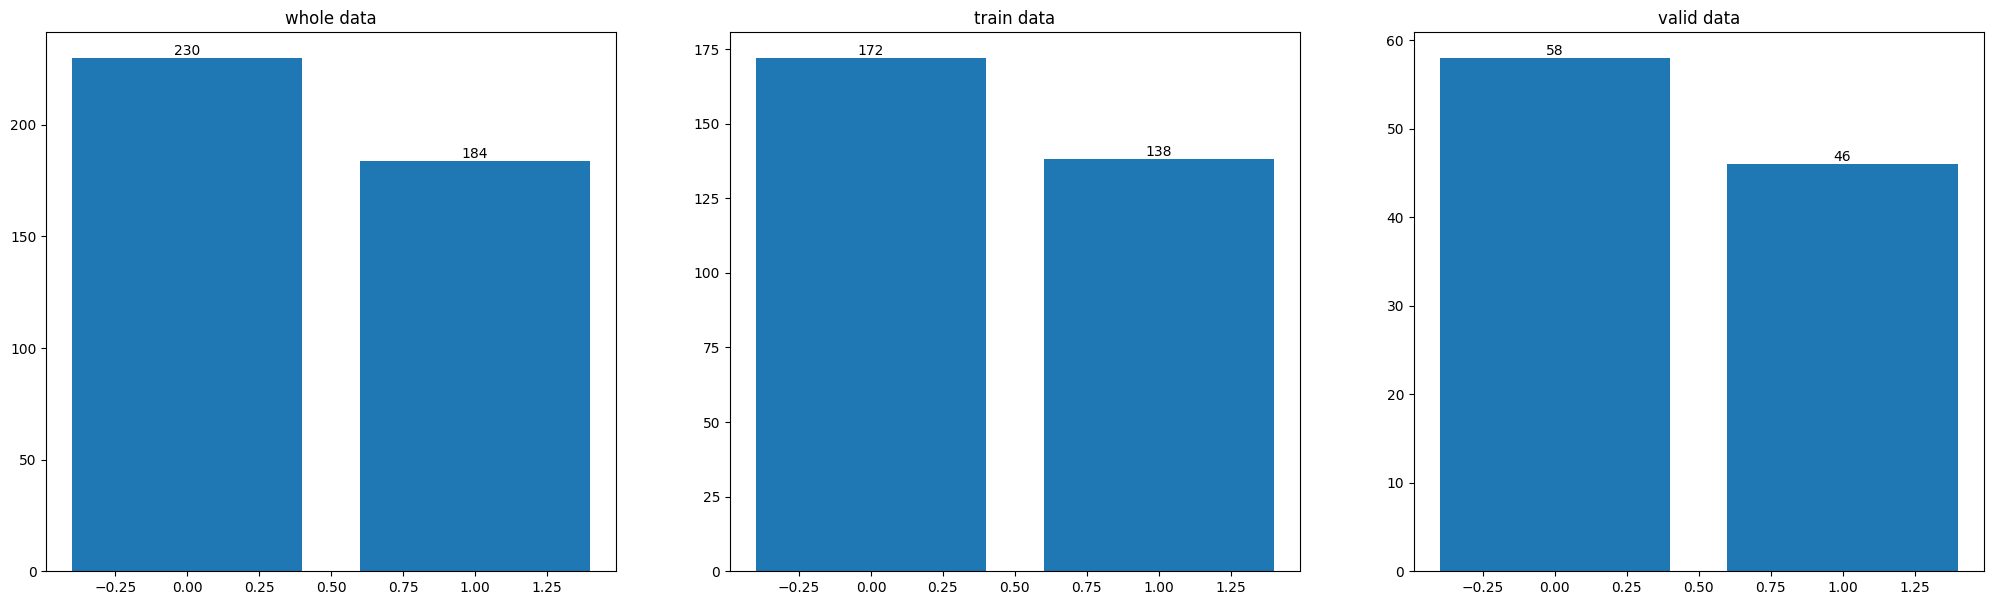

In [8]:
draw_distribution([
                   train_target_cnt      , 
                   train_y.value_counts(), 
                   valid_y.value_counts()
                ])

[param = 1]
train score : 1.000
valid score : 0.558

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       138

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        58
           1       0.50      0.50      0.50        46

    accuracy                           0.56       104
   macro avg       0.55      0.55      0.55       104
weighted avg       0.56      0.56      0.56       104

----------------------------------------------------------------------------------------------------

[param = 5]
train score : 0.723
valid score : 0.625

[train report] 
              precision    recall  f1-score   support

           0       0.72      0.81

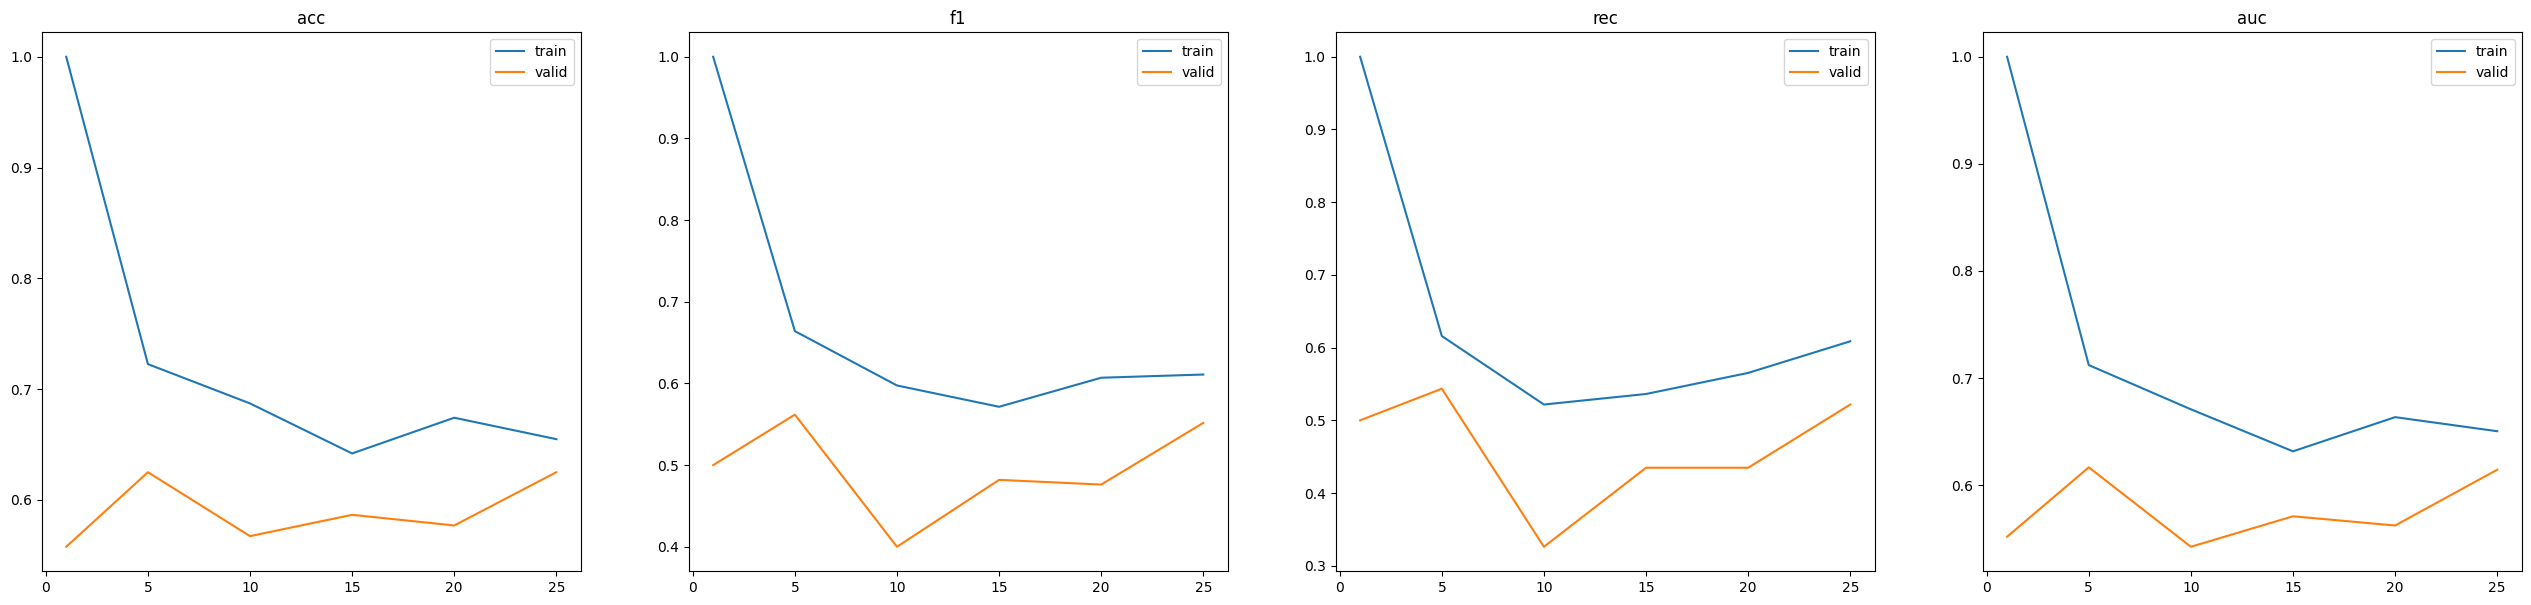

In [9]:
total_metric = model_learning('knn', K, datas)

[param = 0.1]
train score : 0.619
valid score : 0.606

[train report] 
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       172
           1       0.58      0.54      0.56       138

    accuracy                           0.62       310
   macro avg       0.61      0.61      0.61       310
weighted avg       0.62      0.62      0.62       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.63      0.69      0.66        58
           1       0.56      0.50      0.53        46

    accuracy                           0.61       104
   macro avg       0.60      0.59      0.59       104
weighted avg       0.60      0.61      0.60       104

----------------------------------------------------------------------------------------------------

[param = 0.5]
train score : 0.639
valid score : 0.596

[train report] 
              precision    recall  f1-score   support

           0       0.69      

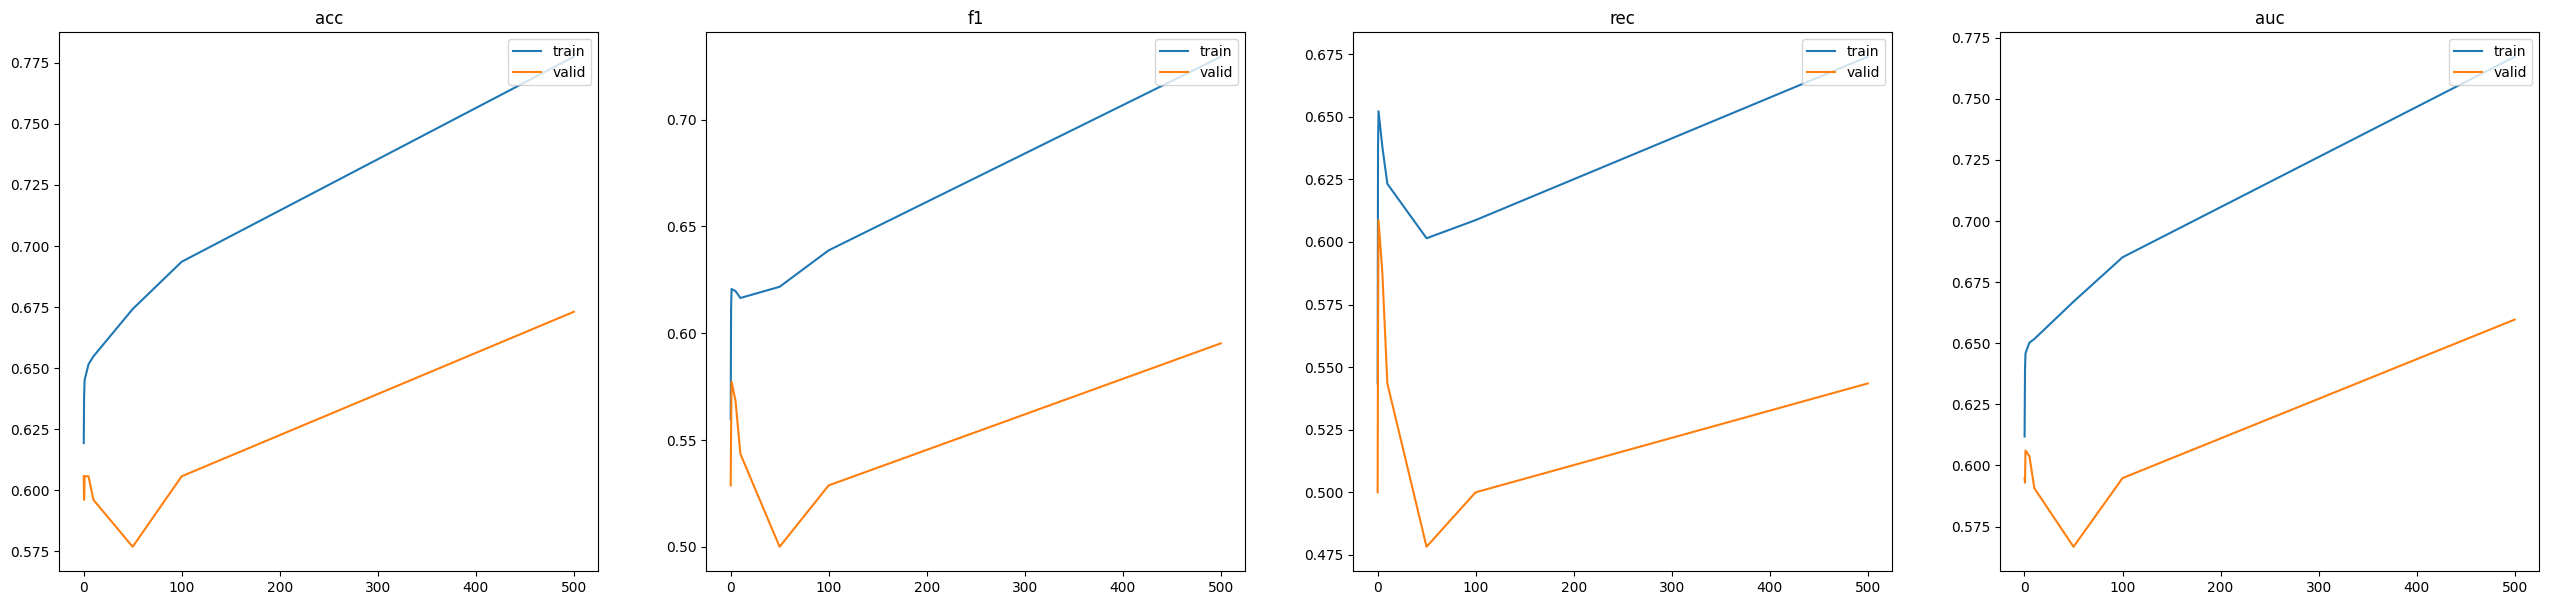

In [10]:
total_metric = model_learning('svc', C, datas)

[param = 75]
train score : 0.948
valid score : 0.731

[train report] 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       172
           1       0.94      0.95      0.94       138

    accuracy                           0.95       310
   macro avg       0.95      0.95      0.95       310
weighted avg       0.95      0.95      0.95       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        58
           1       0.72      0.63      0.67        46

    accuracy                           0.73       104
   macro avg       0.73      0.72      0.72       104
weighted avg       0.73      0.73      0.73       104

----------------------------------------------------------------------------------------------------

[param = 100]
train score : 0.971
valid score : 0.712

[train report] 
              precision    recall  f1-score   support

           0       0.97      0

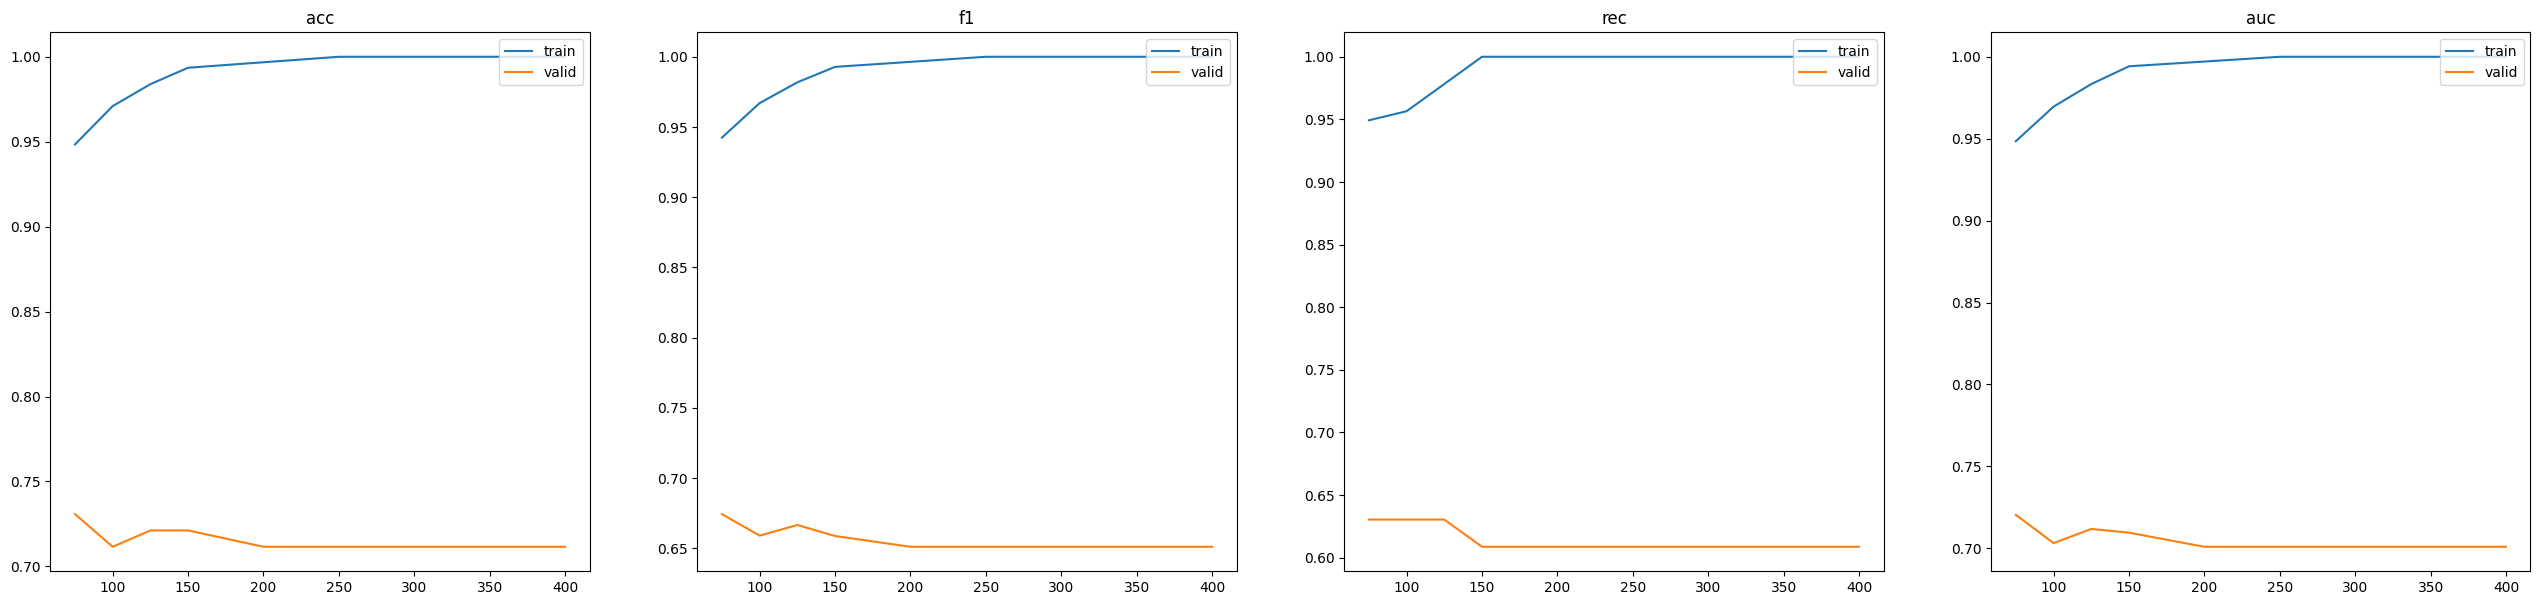

In [11]:
total_metric = model_learning('gboost', N, datas)

[param = 75]
train score : 1.000
valid score : 0.702

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       138

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        58
           1       0.70      0.57      0.63        46

    accuracy                           0.70       104
   macro avg       0.70      0.69      0.69       104
weighted avg       0.70      0.70      0.70       104

----------------------------------------------------------------------------------------------------

[param = 100]
train score : 1.000
valid score : 0.692

[train report] 
              precision    recall  f1-score   support

           0       1.00      1

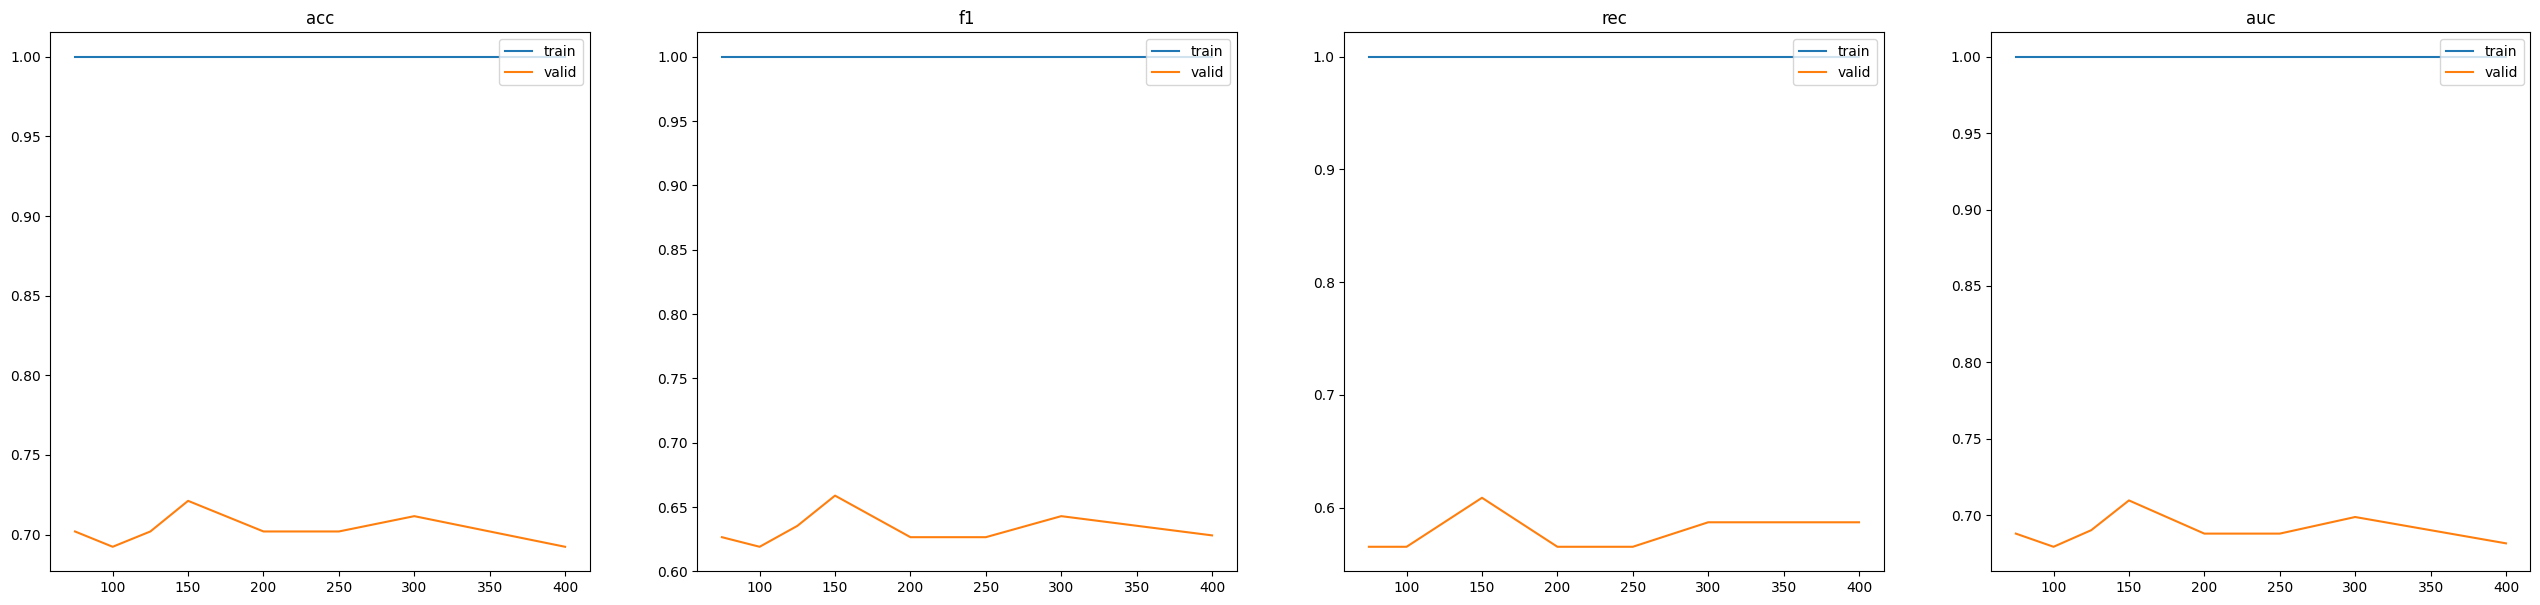

In [12]:
total_metric = model_learning('rf', N, datas)

In [13]:
scaler   = StandardScaler()
train_x_ = scaler.fit_transform(train_x)
valid_x_ = scaler.transform(valid_x)

datas   = [train_x_, valid_x_, train_y, valid_y]

[param = 1]
train score : 1.000
valid score : 0.663

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       138

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        58
           1       0.64      0.54      0.59        46

    accuracy                           0.66       104
   macro avg       0.66      0.65      0.65       104
weighted avg       0.66      0.66      0.66       104

----------------------------------------------------------------------------------------------------

[param = 5]
train score : 0.787
valid score : 0.702

[train report] 
              precision    recall  f1-score   support

           0       0.80      0.83

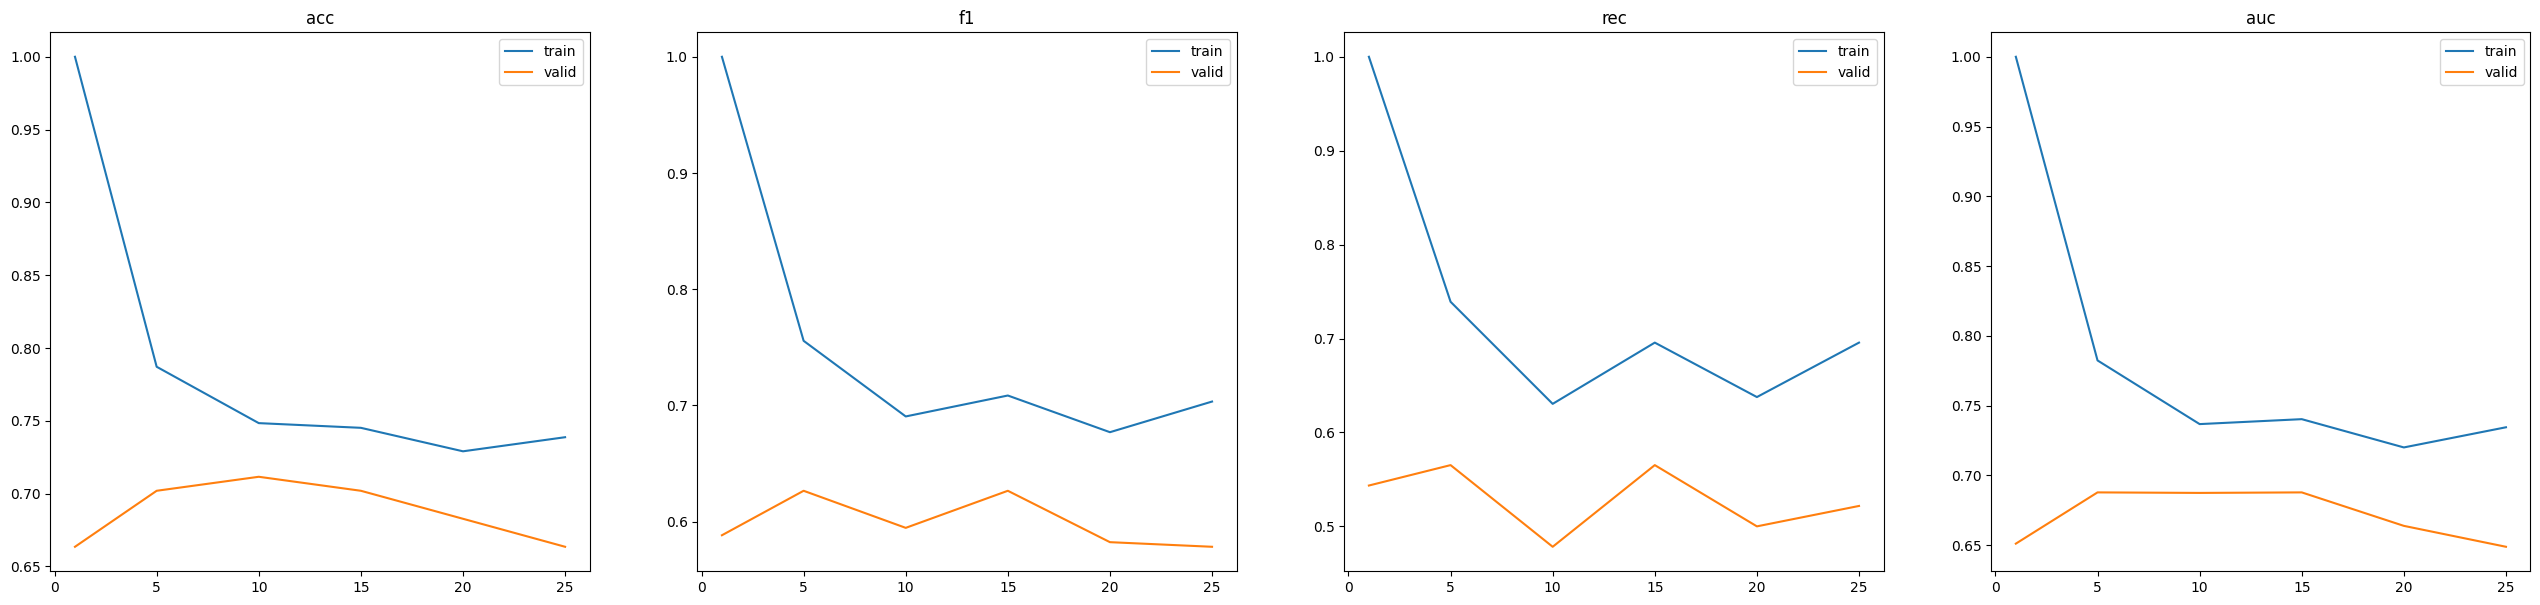

In [14]:
total_metric = model_learning('knn', K, datas, method = 'standard')

[param = 0.1]
train score : 0.771
valid score : 0.692

[train report] 
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       172
           1       0.80      0.65      0.72       138

    accuracy                           0.77       310
   macro avg       0.78      0.76      0.76       310
weighted avg       0.77      0.77      0.77       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        58
           1       0.75      0.46      0.57        46

    accuracy                           0.69       104
   macro avg       0.71      0.67      0.66       104
weighted avg       0.71      0.69      0.68       104

----------------------------------------------------------------------------------------------------

[param = 0.5]
train score : 0.797
valid score : 0.702

[train report] 
              precision    recall  f1-score   support

           0       0.78      

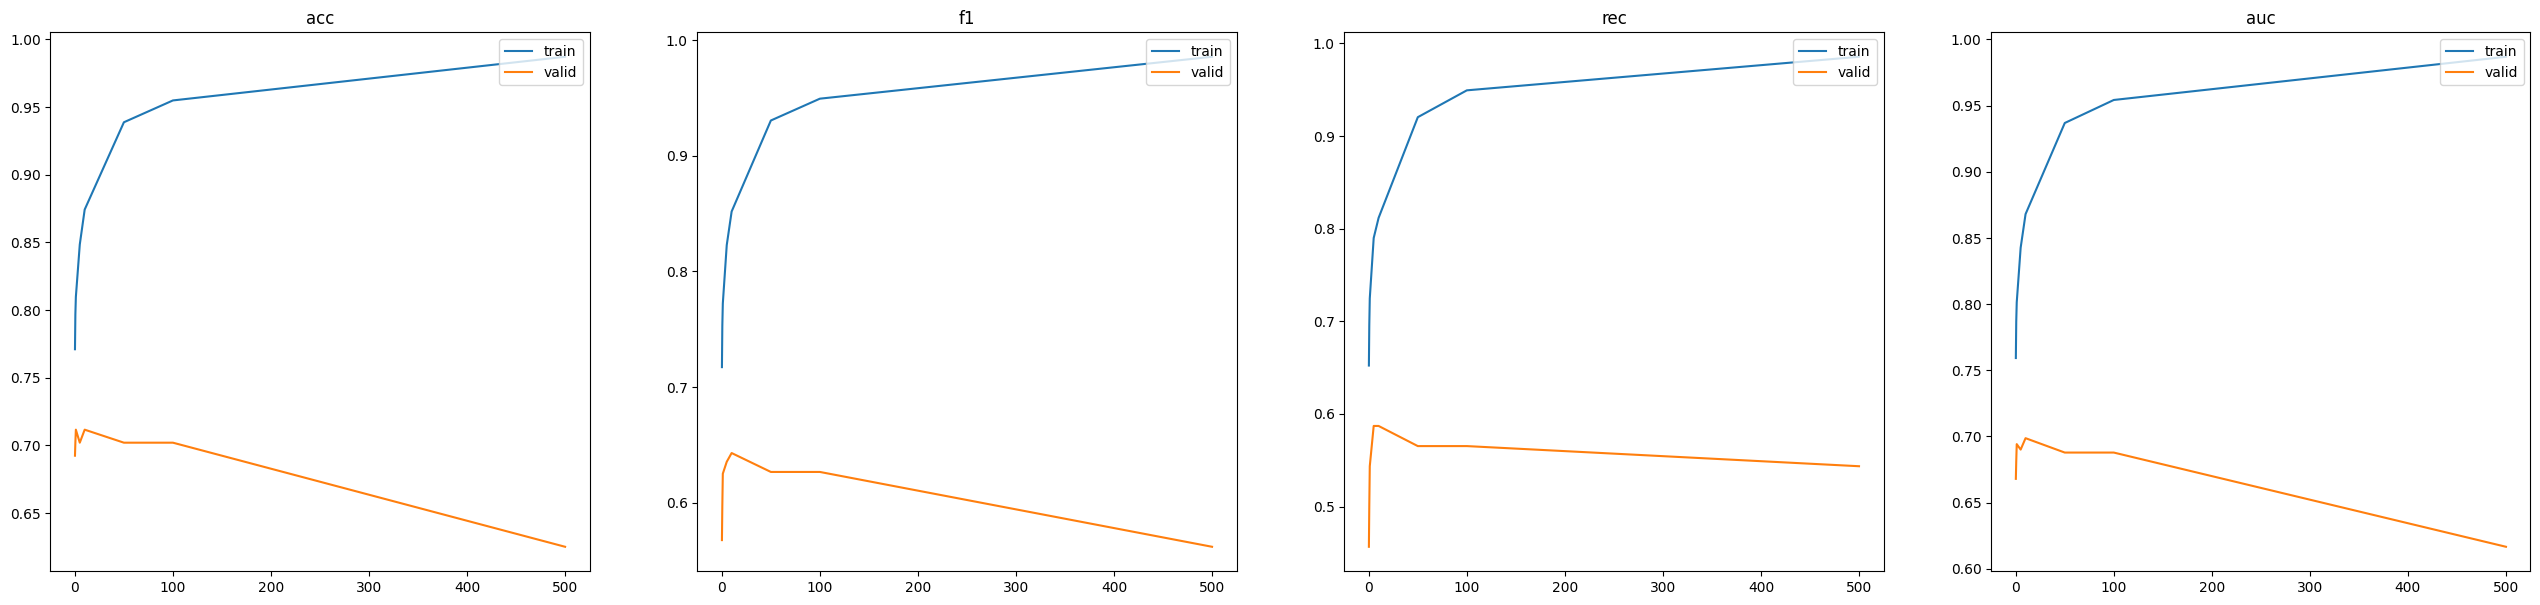

In [15]:
total_metric = model_learning('svc', C, datas, 'standard')

[param = 75]
train score : 0.939
valid score : 0.702

[train report] 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       172
           1       0.94      0.92      0.93       138

    accuracy                           0.94       310
   macro avg       0.94      0.94      0.94       310
weighted avg       0.94      0.94      0.94       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        58
           1       0.68      0.61      0.64        46

    accuracy                           0.70       104
   macro avg       0.70      0.69      0.69       104
weighted avg       0.70      0.70      0.70       104

----------------------------------------------------------------------------------------------------

[param = 100]
train score : 0.971
valid score : 0.712

[train report] 
              precision    recall  f1-score   support

           0       0.97      0

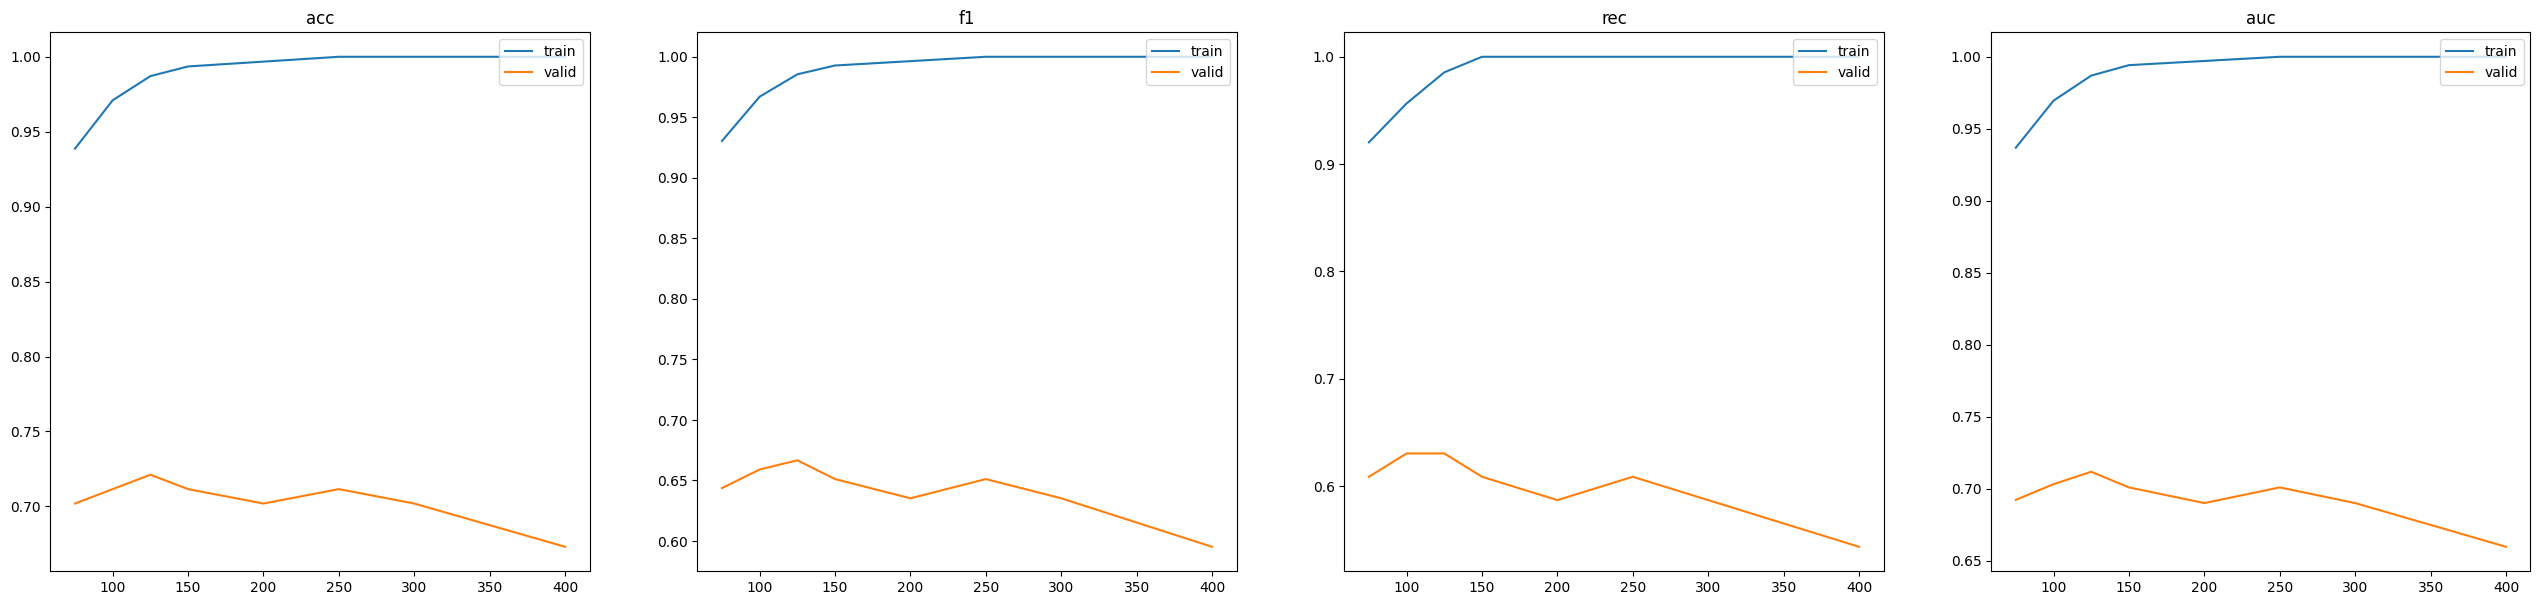

In [16]:
total_metric = model_learning('gboost', N, datas, method = 'standard')

[param = 75]
train score : 1.000
valid score : 0.673

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       138

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.69      0.74      0.72        58
           1       0.64      0.59      0.61        46

    accuracy                           0.67       104
   macro avg       0.67      0.66      0.67       104
weighted avg       0.67      0.67      0.67       104

----------------------------------------------------------------------------------------------------

[param = 100]
train score : 1.000
valid score : 0.721

[train report] 
              precision    recall  f1-score   support

           0       1.00      1

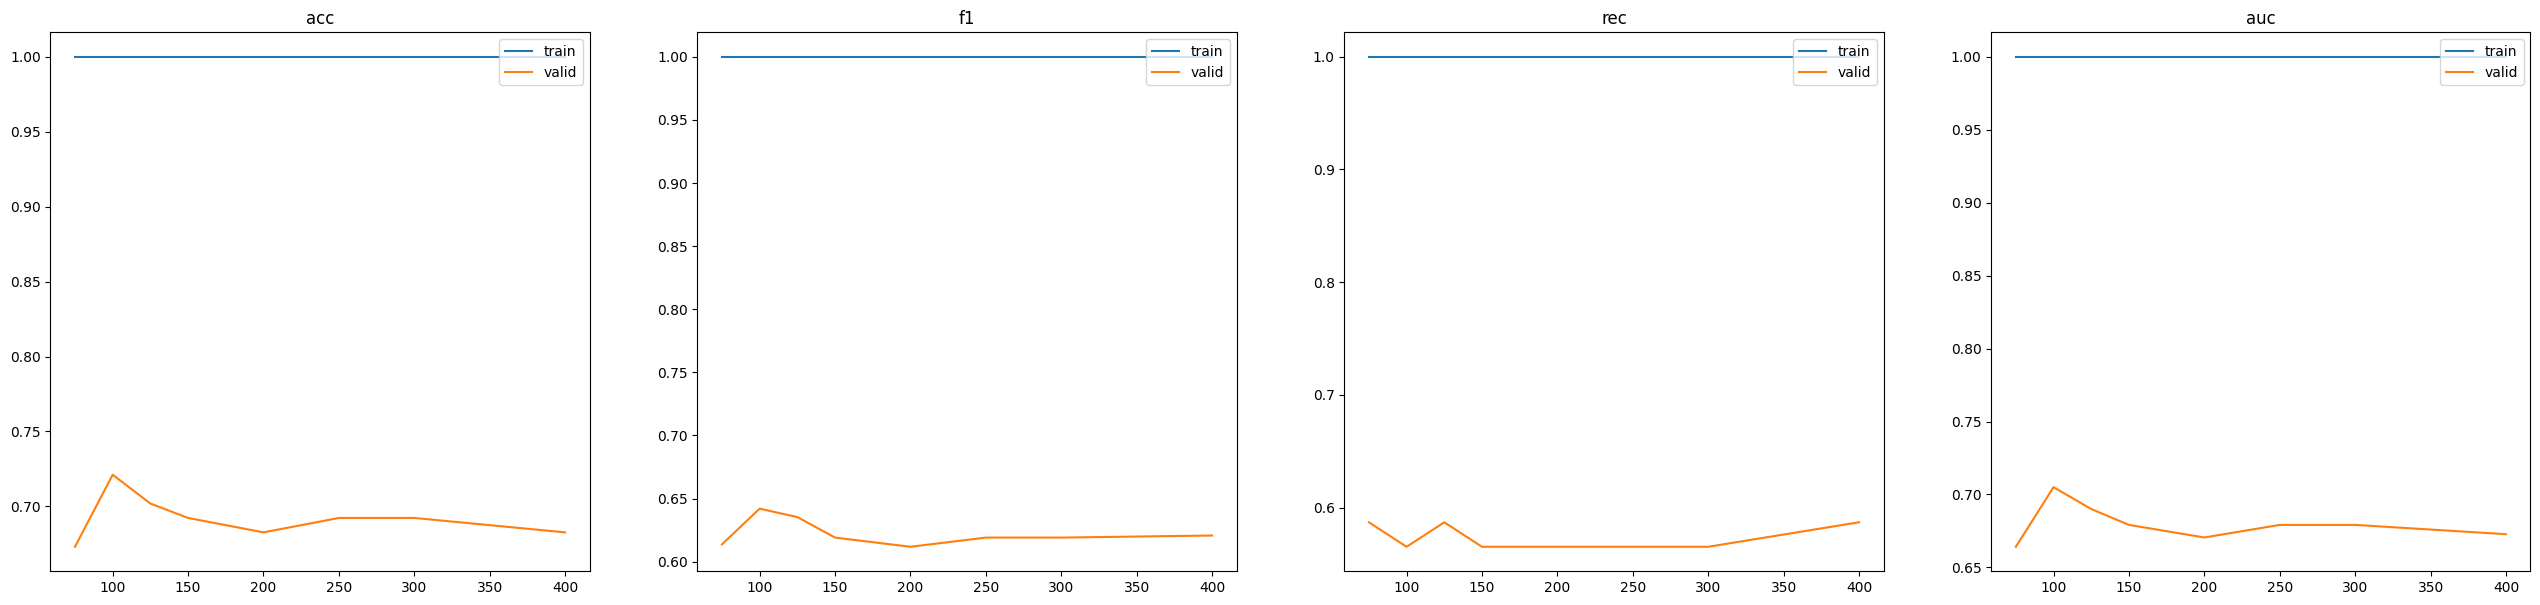

In [17]:
total_metric  = model_learning('rf', N, datas, method = 'standard')

In [18]:
scaler   = MinMaxScaler()
train_x_ = scaler.fit_transform(train_x)
valid_x_ = scaler.transform(valid_x)
datas    = [train_x_, valid_x_, train_y, valid_y]

[param = 1]
train score : 1.000
valid score : 0.654

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       138

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        58
           1       0.65      0.48      0.55        46

    accuracy                           0.65       104
   macro avg       0.65      0.64      0.63       104
weighted avg       0.65      0.65      0.64       104

----------------------------------------------------------------------------------------------------

[param = 5]
train score : 0.787
valid score : 0.683

[train report] 
              precision    recall  f1-score   support

           0       0.80      0.82

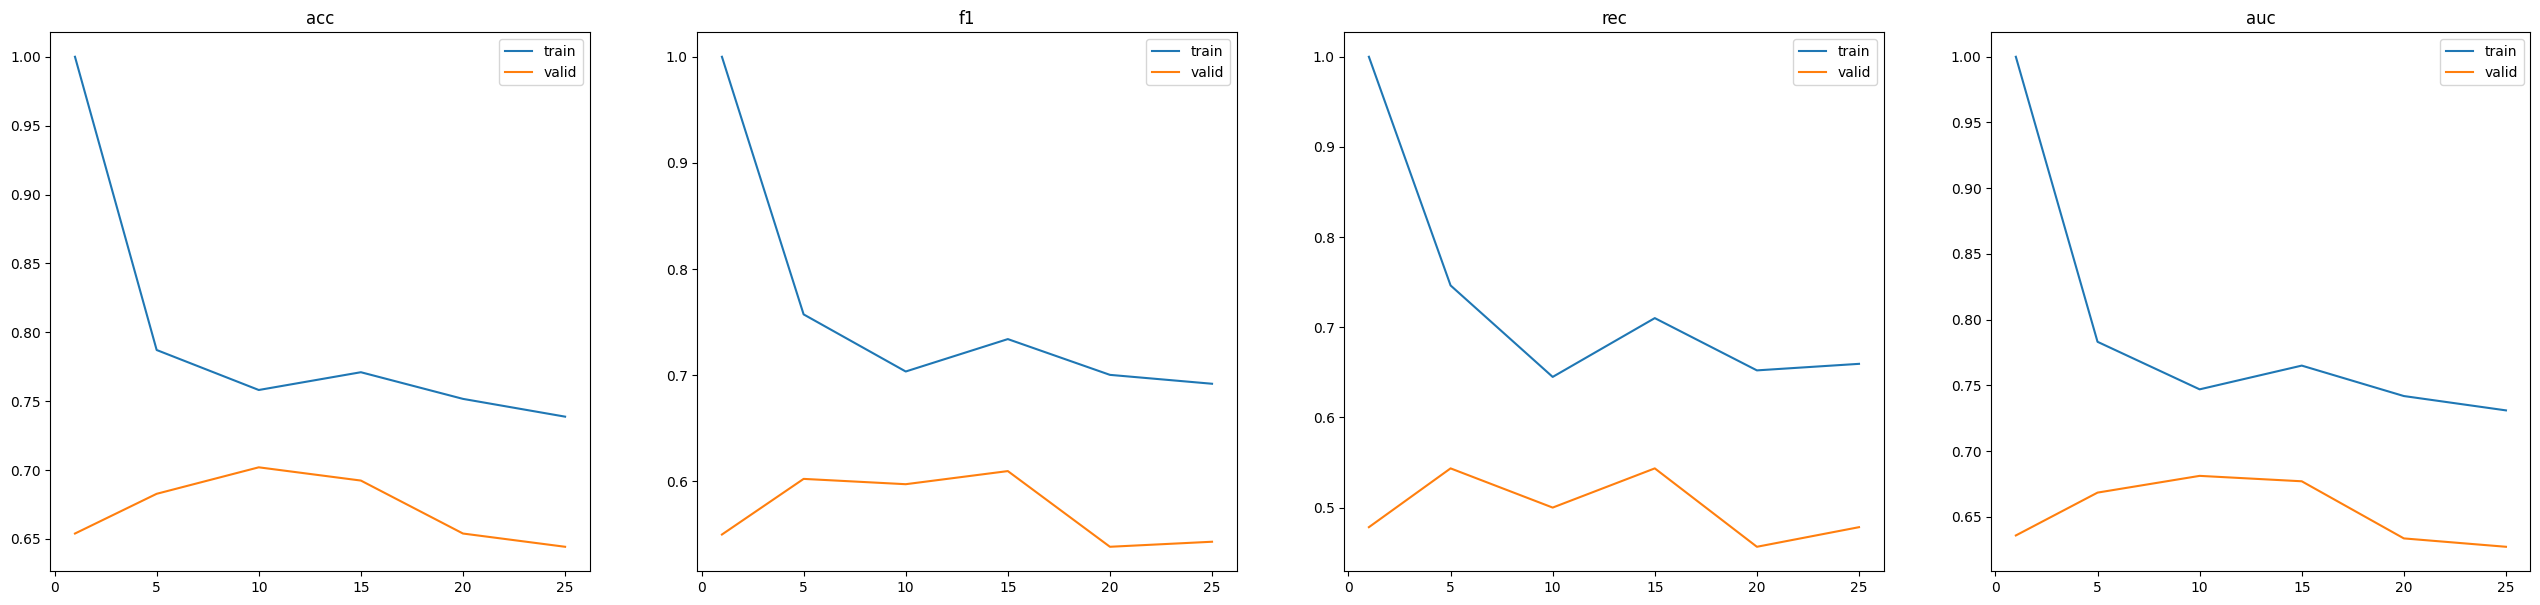

In [19]:
total_metric = model_learning('knn', K, datas, method = 'MinMax')

[param = 0.1]
train score : 0.768
valid score : 0.683

[train report] 
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       172
           1       0.80      0.64      0.71       138

    accuracy                           0.77       310
   macro avg       0.78      0.75      0.76       310
weighted avg       0.77      0.77      0.76       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.67      0.86      0.75        58
           1       0.72      0.46      0.56        46

    accuracy                           0.68       104
   macro avg       0.70      0.66      0.66       104
weighted avg       0.69      0.68      0.67       104

----------------------------------------------------------------------------------------------------

[param = 0.5]
train score : 0.794
valid score : 0.712

[train report] 
              precision    recall  f1-score   support

           0       0.78      

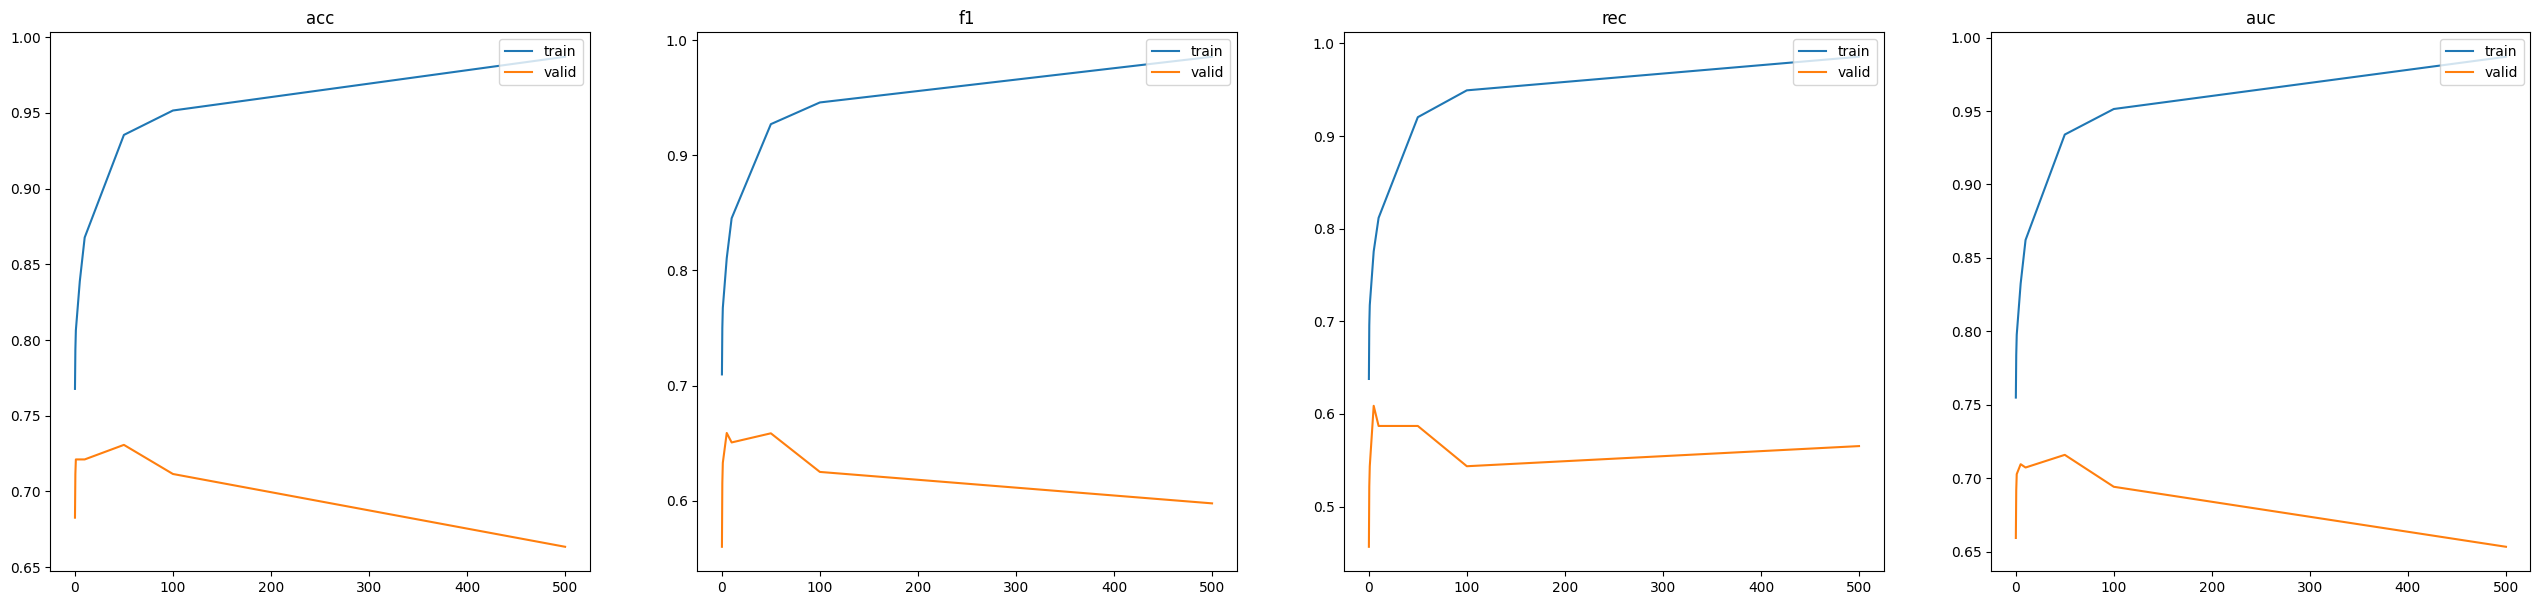

In [20]:
total_metric = model_learning('svc', C, datas, method = 'MinMax')

[param = 75]
train score : 0.939
valid score : 0.702

[train report] 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       172
           1       0.94      0.92      0.93       138

    accuracy                           0.94       310
   macro avg       0.94      0.94      0.94       310
weighted avg       0.94      0.94      0.94       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        58
           1       0.68      0.61      0.64        46

    accuracy                           0.70       104
   macro avg       0.70      0.69      0.69       104
weighted avg       0.70      0.70      0.70       104

----------------------------------------------------------------------------------------------------

[param = 100]
train score : 0.977
valid score : 0.721

[train report] 
              precision    recall  f1-score   support

           0       0.98      0

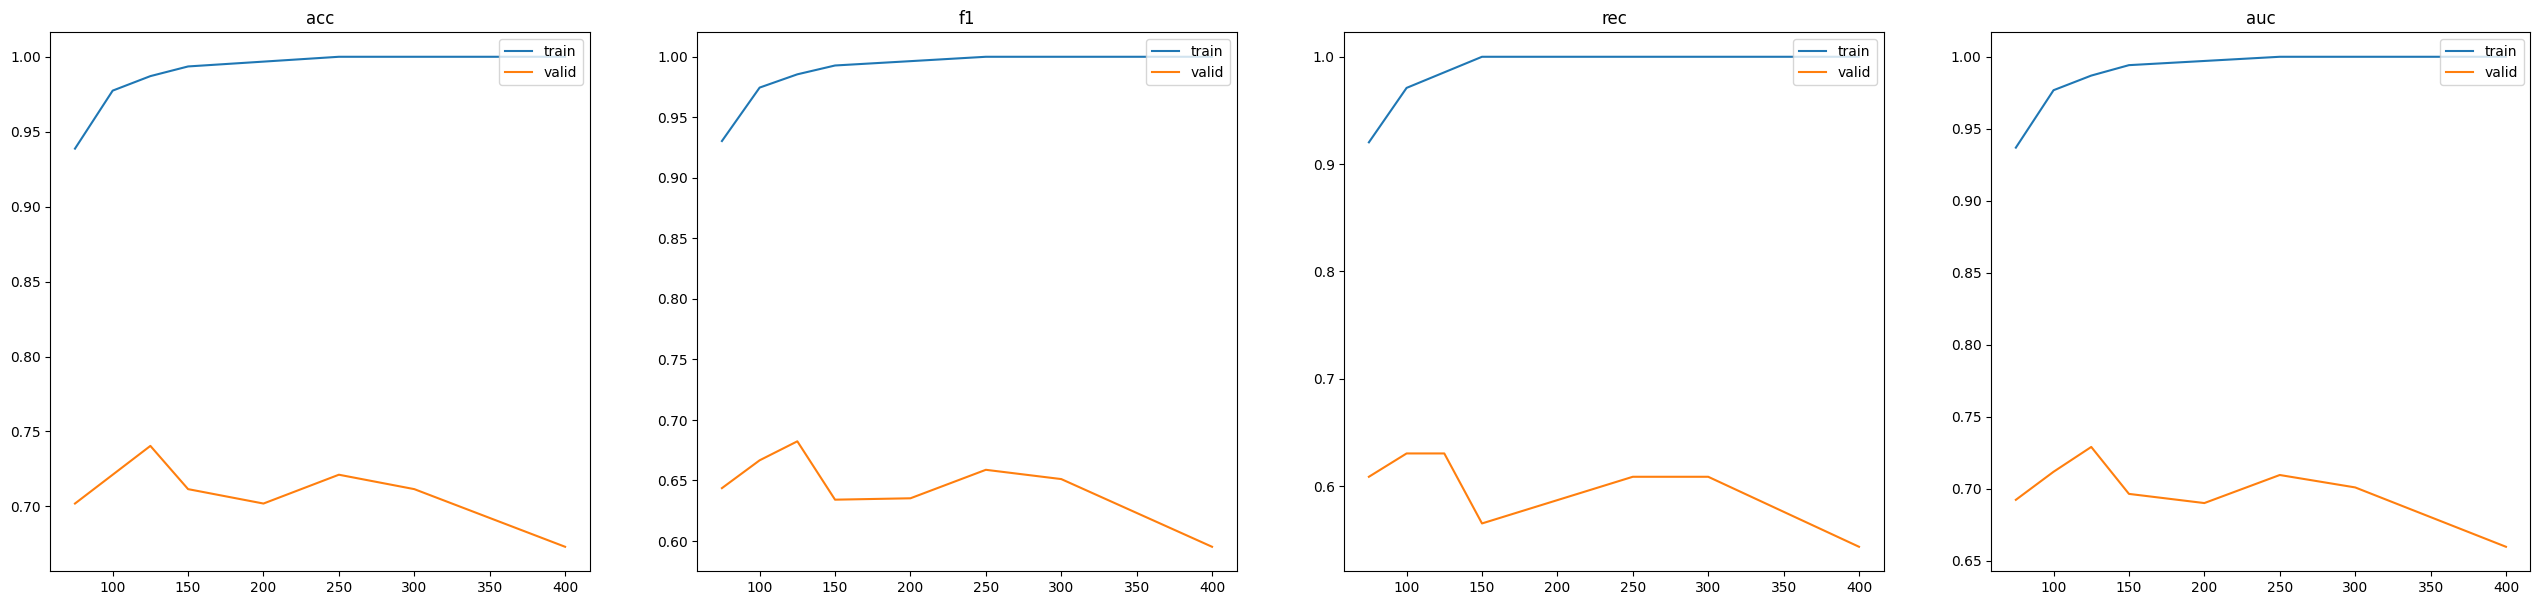

In [21]:
total_metric = model_learning('gboost', N, datas, method = 'MinMax')

[param = 75]
train score : 1.000
valid score : 0.721

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       138

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        58
           1       0.72      0.61      0.66        46

    accuracy                           0.72       104
   macro avg       0.72      0.71      0.71       104
weighted avg       0.72      0.72      0.72       104

----------------------------------------------------------------------------------------------------

[param = 100]
train score : 1.000
valid score : 0.712

[train report] 
              precision    recall  f1-score   support

           0       1.00      1

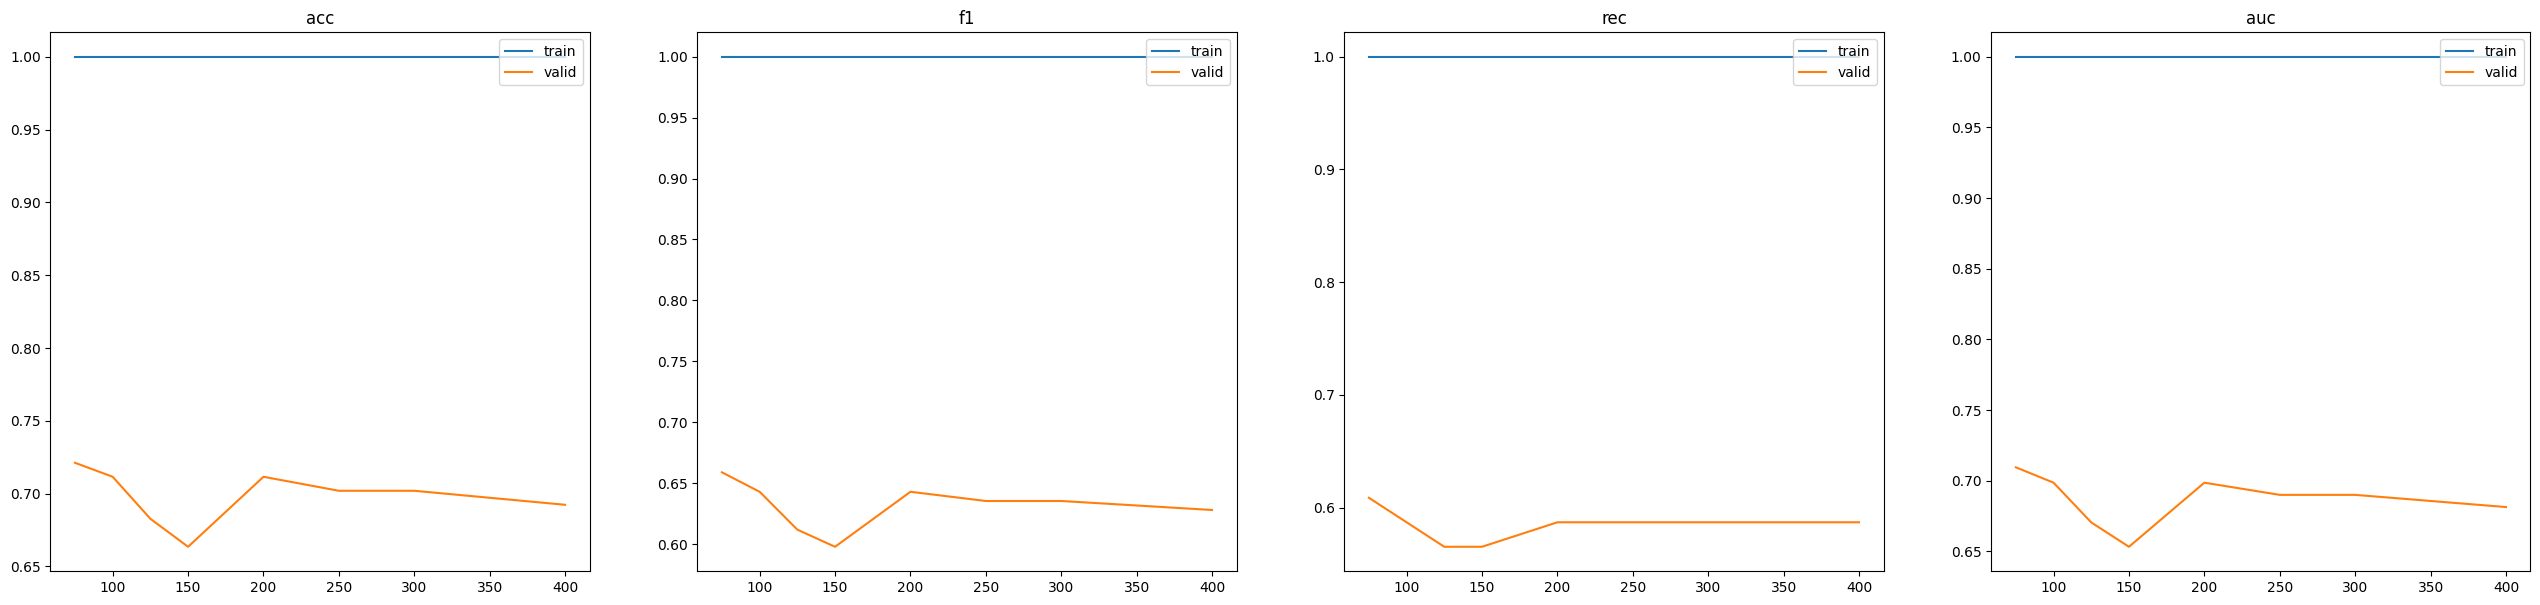

In [22]:
total_metric = model_learning('rf', N, datas, method = 'MinMax')

In [23]:
smote                  = SMOTE(sampling_strategy = 1)
train_x_sm, train_y_sm = smote.fit_resample(train_x, train_y)

scaler                 = StandardScaler()
train_x_sm             = scaler.fit_transform(train_x_sm)
valid_x_               = scaler.transform(valid_x)
datas                  = [train_x_sm, valid_x_, train_y_sm, valid_y]

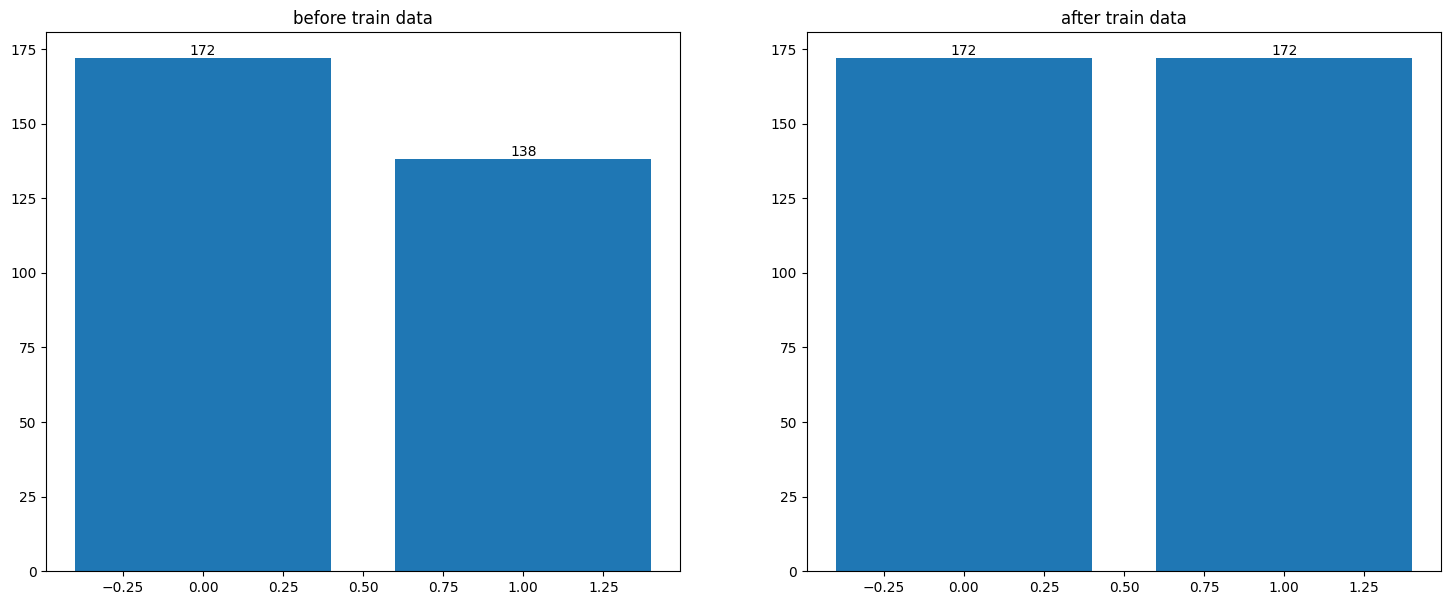

In [24]:
draw_distribution([
                   train_y.value_counts()   , 
                   train_y_sm.value_counts(), 
                ], titles = ['before train', 'after train'])

[param = 1]
train score : 1.000
valid score : 0.702

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       172

    accuracy                           1.00       344
   macro avg       1.00      1.00      1.00       344
weighted avg       1.00      1.00      1.00       344
 

[valid report] 
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        58
           1       0.69      0.59      0.64        46

    accuracy                           0.70       104
   macro avg       0.70      0.69      0.69       104
weighted avg       0.70      0.70      0.70       104

----------------------------------------------------------------------------------------------------

[param = 5]
train score : 0.811
valid score : 0.683

[train report] 
              precision    recall  f1-score   support

           0       0.83      0.78

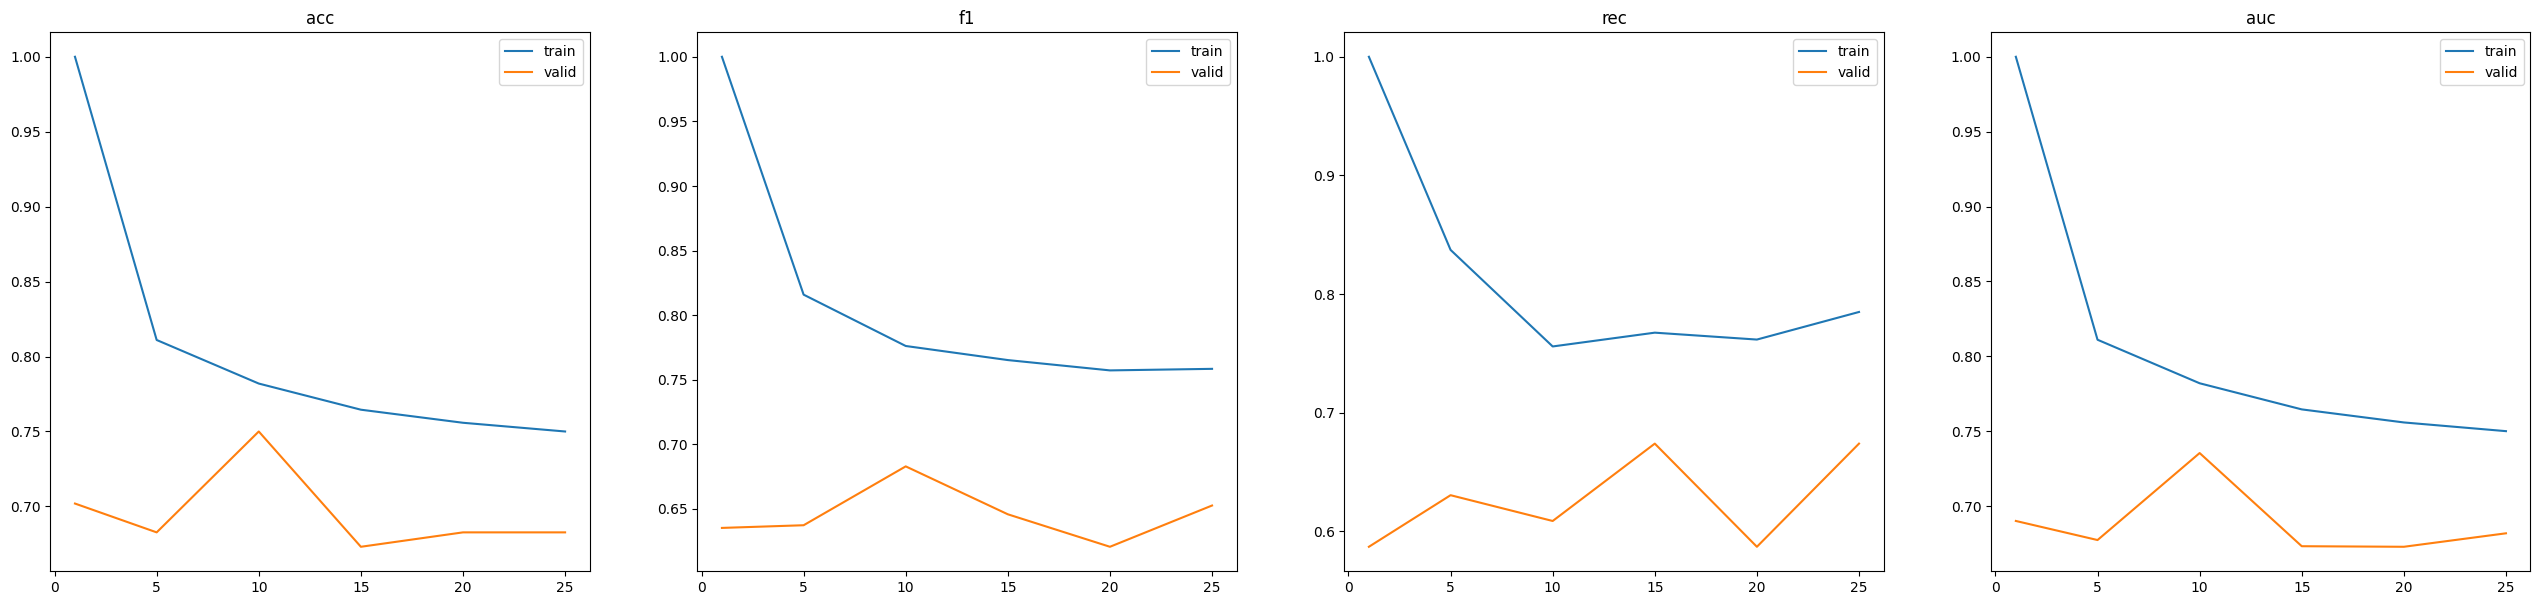

In [25]:
total_metric = model_learning('knn', K, datas, method = 'smote')

[param = 0.1]
train score : 0.750
valid score : 0.663

[train report] 
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       172
           1       0.74      0.77      0.76       172

    accuracy                           0.75       344
   macro avg       0.75      0.75      0.75       344
weighted avg       0.75      0.75      0.75       344
 

[valid report] 
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        58
           1       0.62      0.61      0.62        46

    accuracy                           0.66       104
   macro avg       0.66      0.66      0.66       104
weighted avg       0.66      0.66      0.66       104

----------------------------------------------------------------------------------------------------

[param = 0.5]
train score : 0.805
valid score : 0.712

[train report] 
              precision    recall  f1-score   support

           0       0.80      

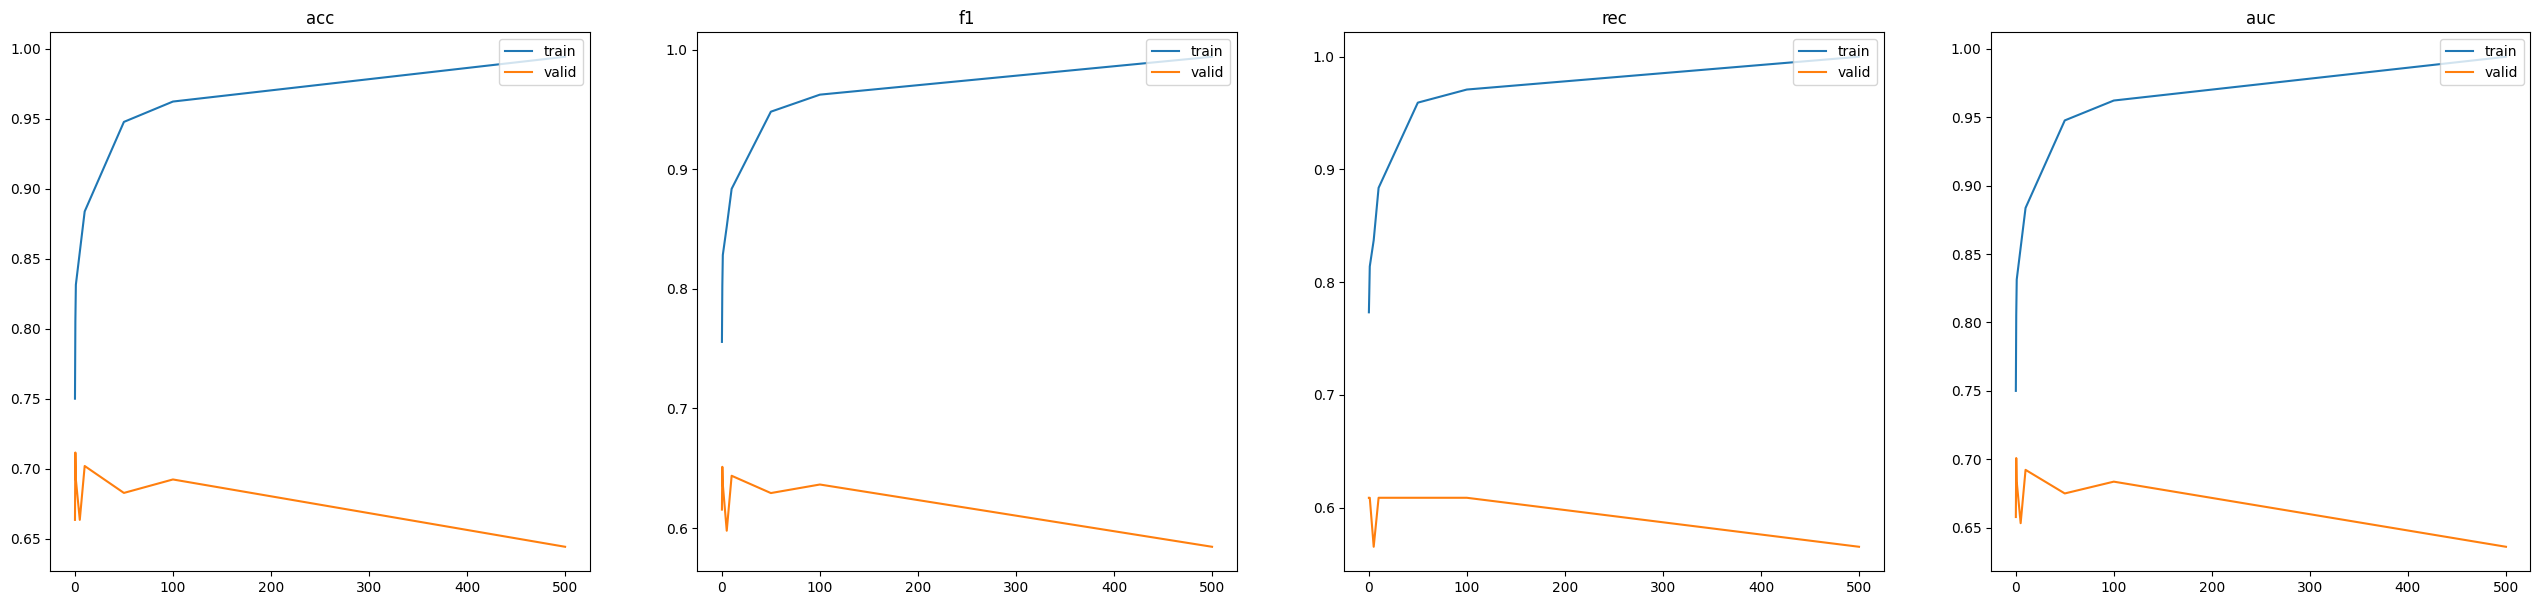

In [26]:
total_metric = model_learning('svc', C, datas, method = 'smote')

[param = 75]
train score : 0.953
valid score : 0.692

[train report] 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       172
           1       0.94      0.97      0.95       172

    accuracy                           0.95       344
   macro avg       0.95      0.95      0.95       344
weighted avg       0.95      0.95      0.95       344
 

[valid report] 
              precision    recall  f1-score   support

           0       0.71      0.76      0.73        58
           1       0.67      0.61      0.64        46

    accuracy                           0.69       104
   macro avg       0.69      0.68      0.68       104
weighted avg       0.69      0.69      0.69       104

----------------------------------------------------------------------------------------------------

[param = 100]
train score : 0.968
valid score : 0.702

[train report] 
              precision    recall  f1-score   support

           0       0.97      0

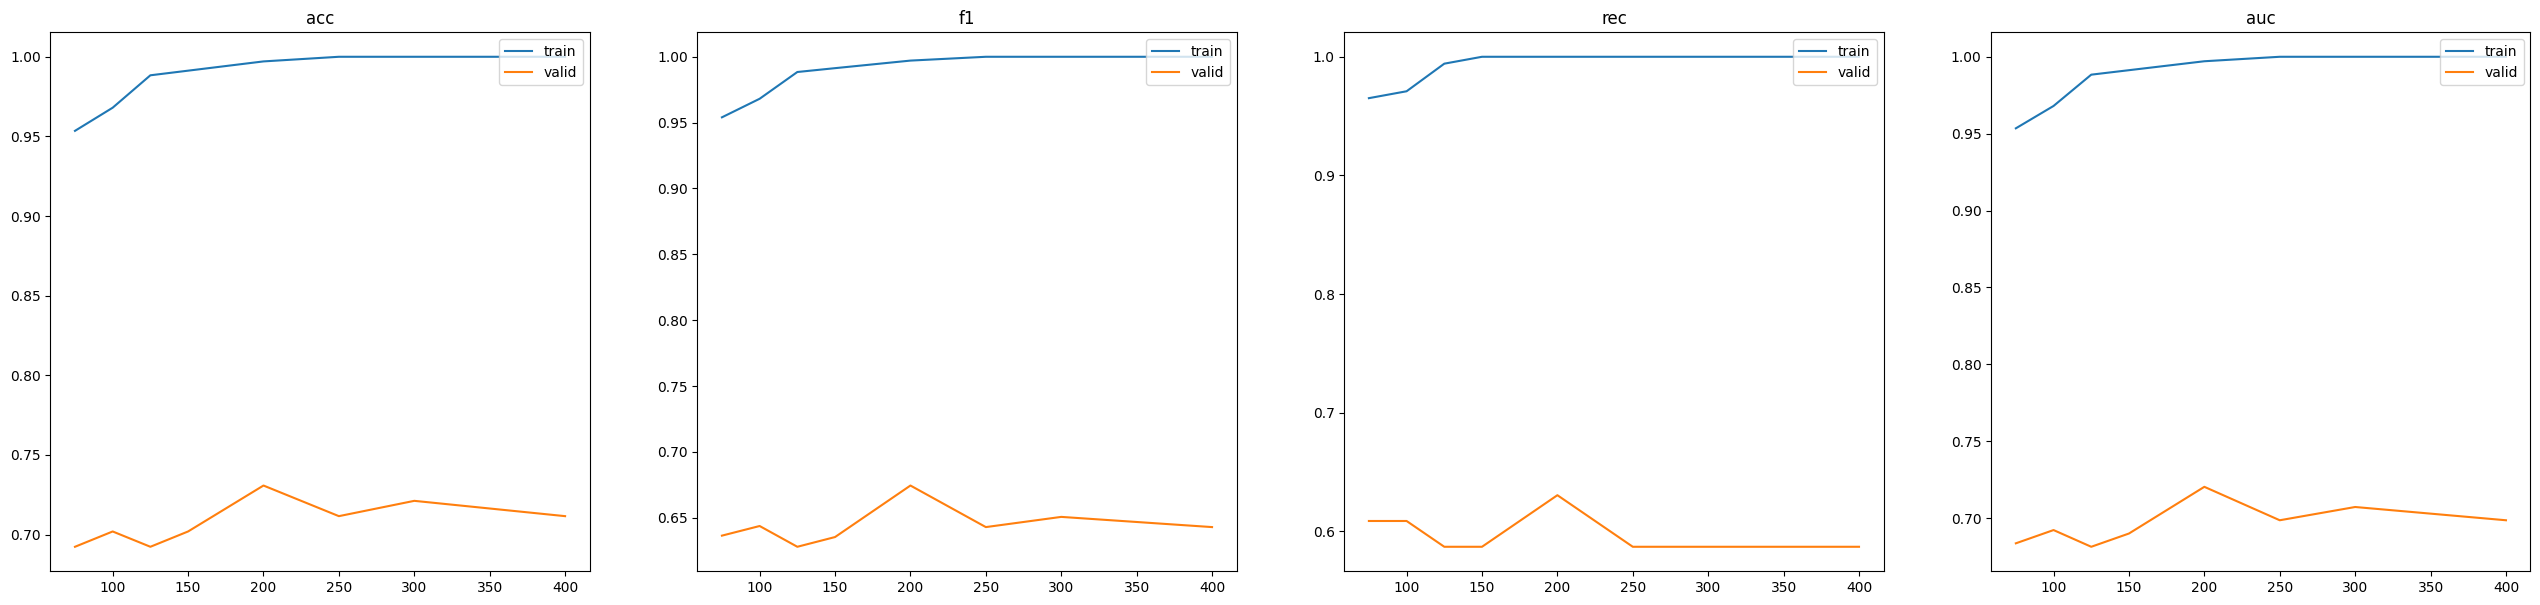

In [27]:
total_metric = model_learning('gboost', N, datas, method = 'smote')

[param = 75]
train score : 1.000
valid score : 0.702

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       172

    accuracy                           1.00       344
   macro avg       1.00      1.00      1.00       344
weighted avg       1.00      1.00      1.00       344
 

[valid report] 
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        58
           1       0.69      0.59      0.64        46

    accuracy                           0.70       104
   macro avg       0.70      0.69      0.69       104
weighted avg       0.70      0.70      0.70       104

----------------------------------------------------------------------------------------------------

[param = 100]
train score : 1.000
valid score : 0.692

[train report] 
              precision    recall  f1-score   support

           0       1.00      1

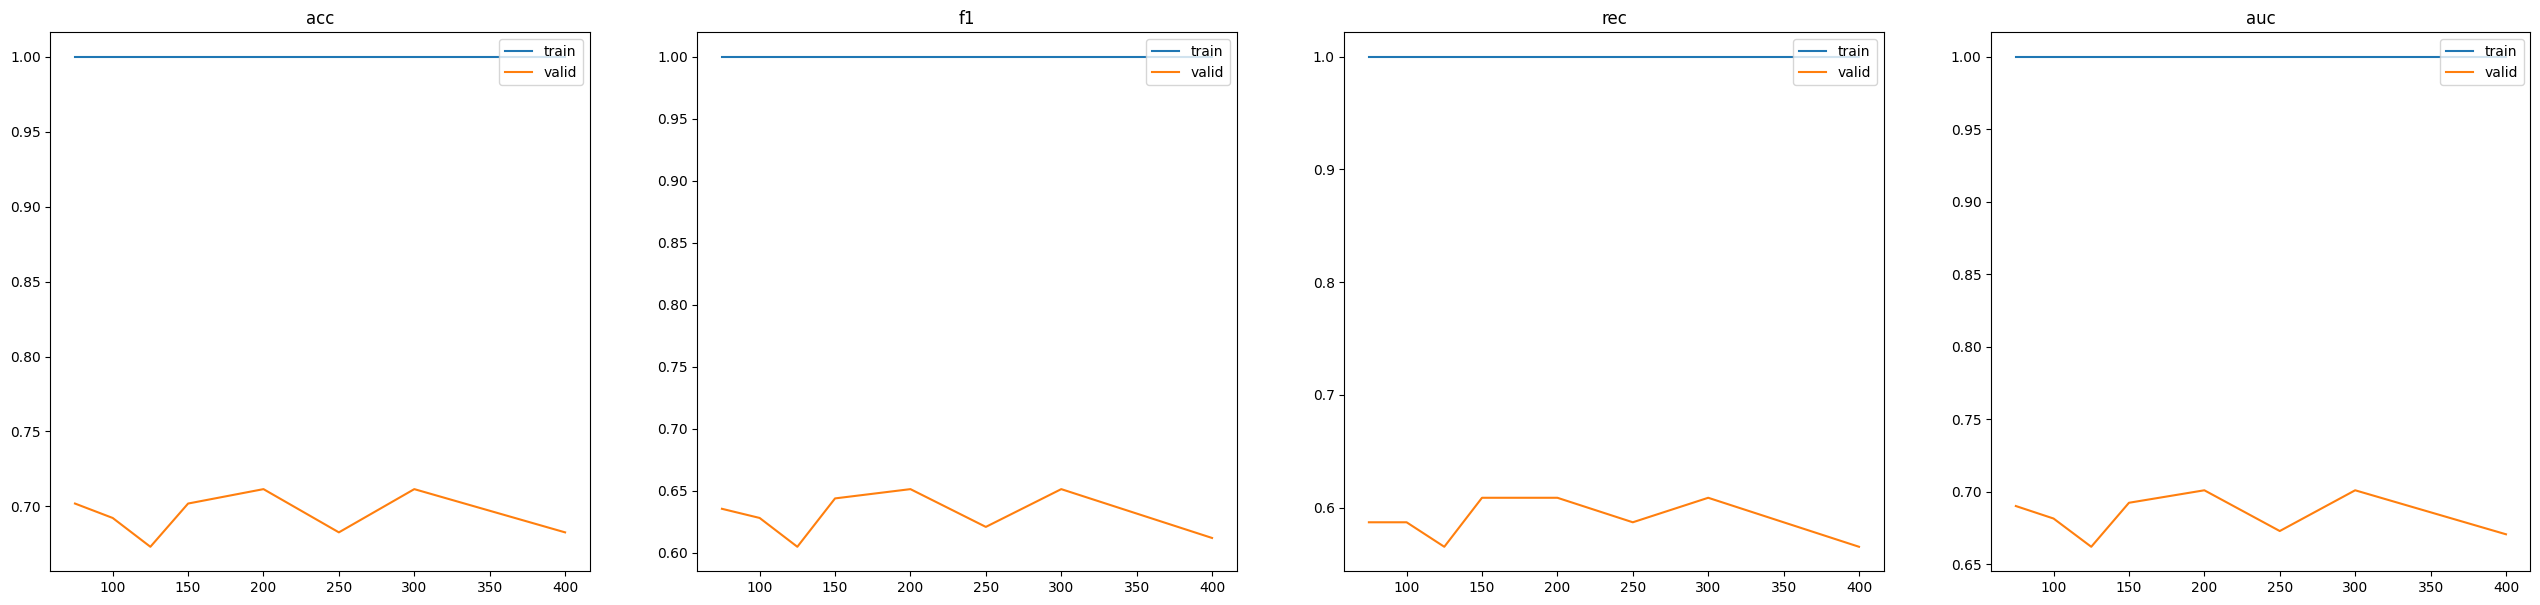

In [28]:
total_metric = model_learning('rf', N, datas, method = 'smote')

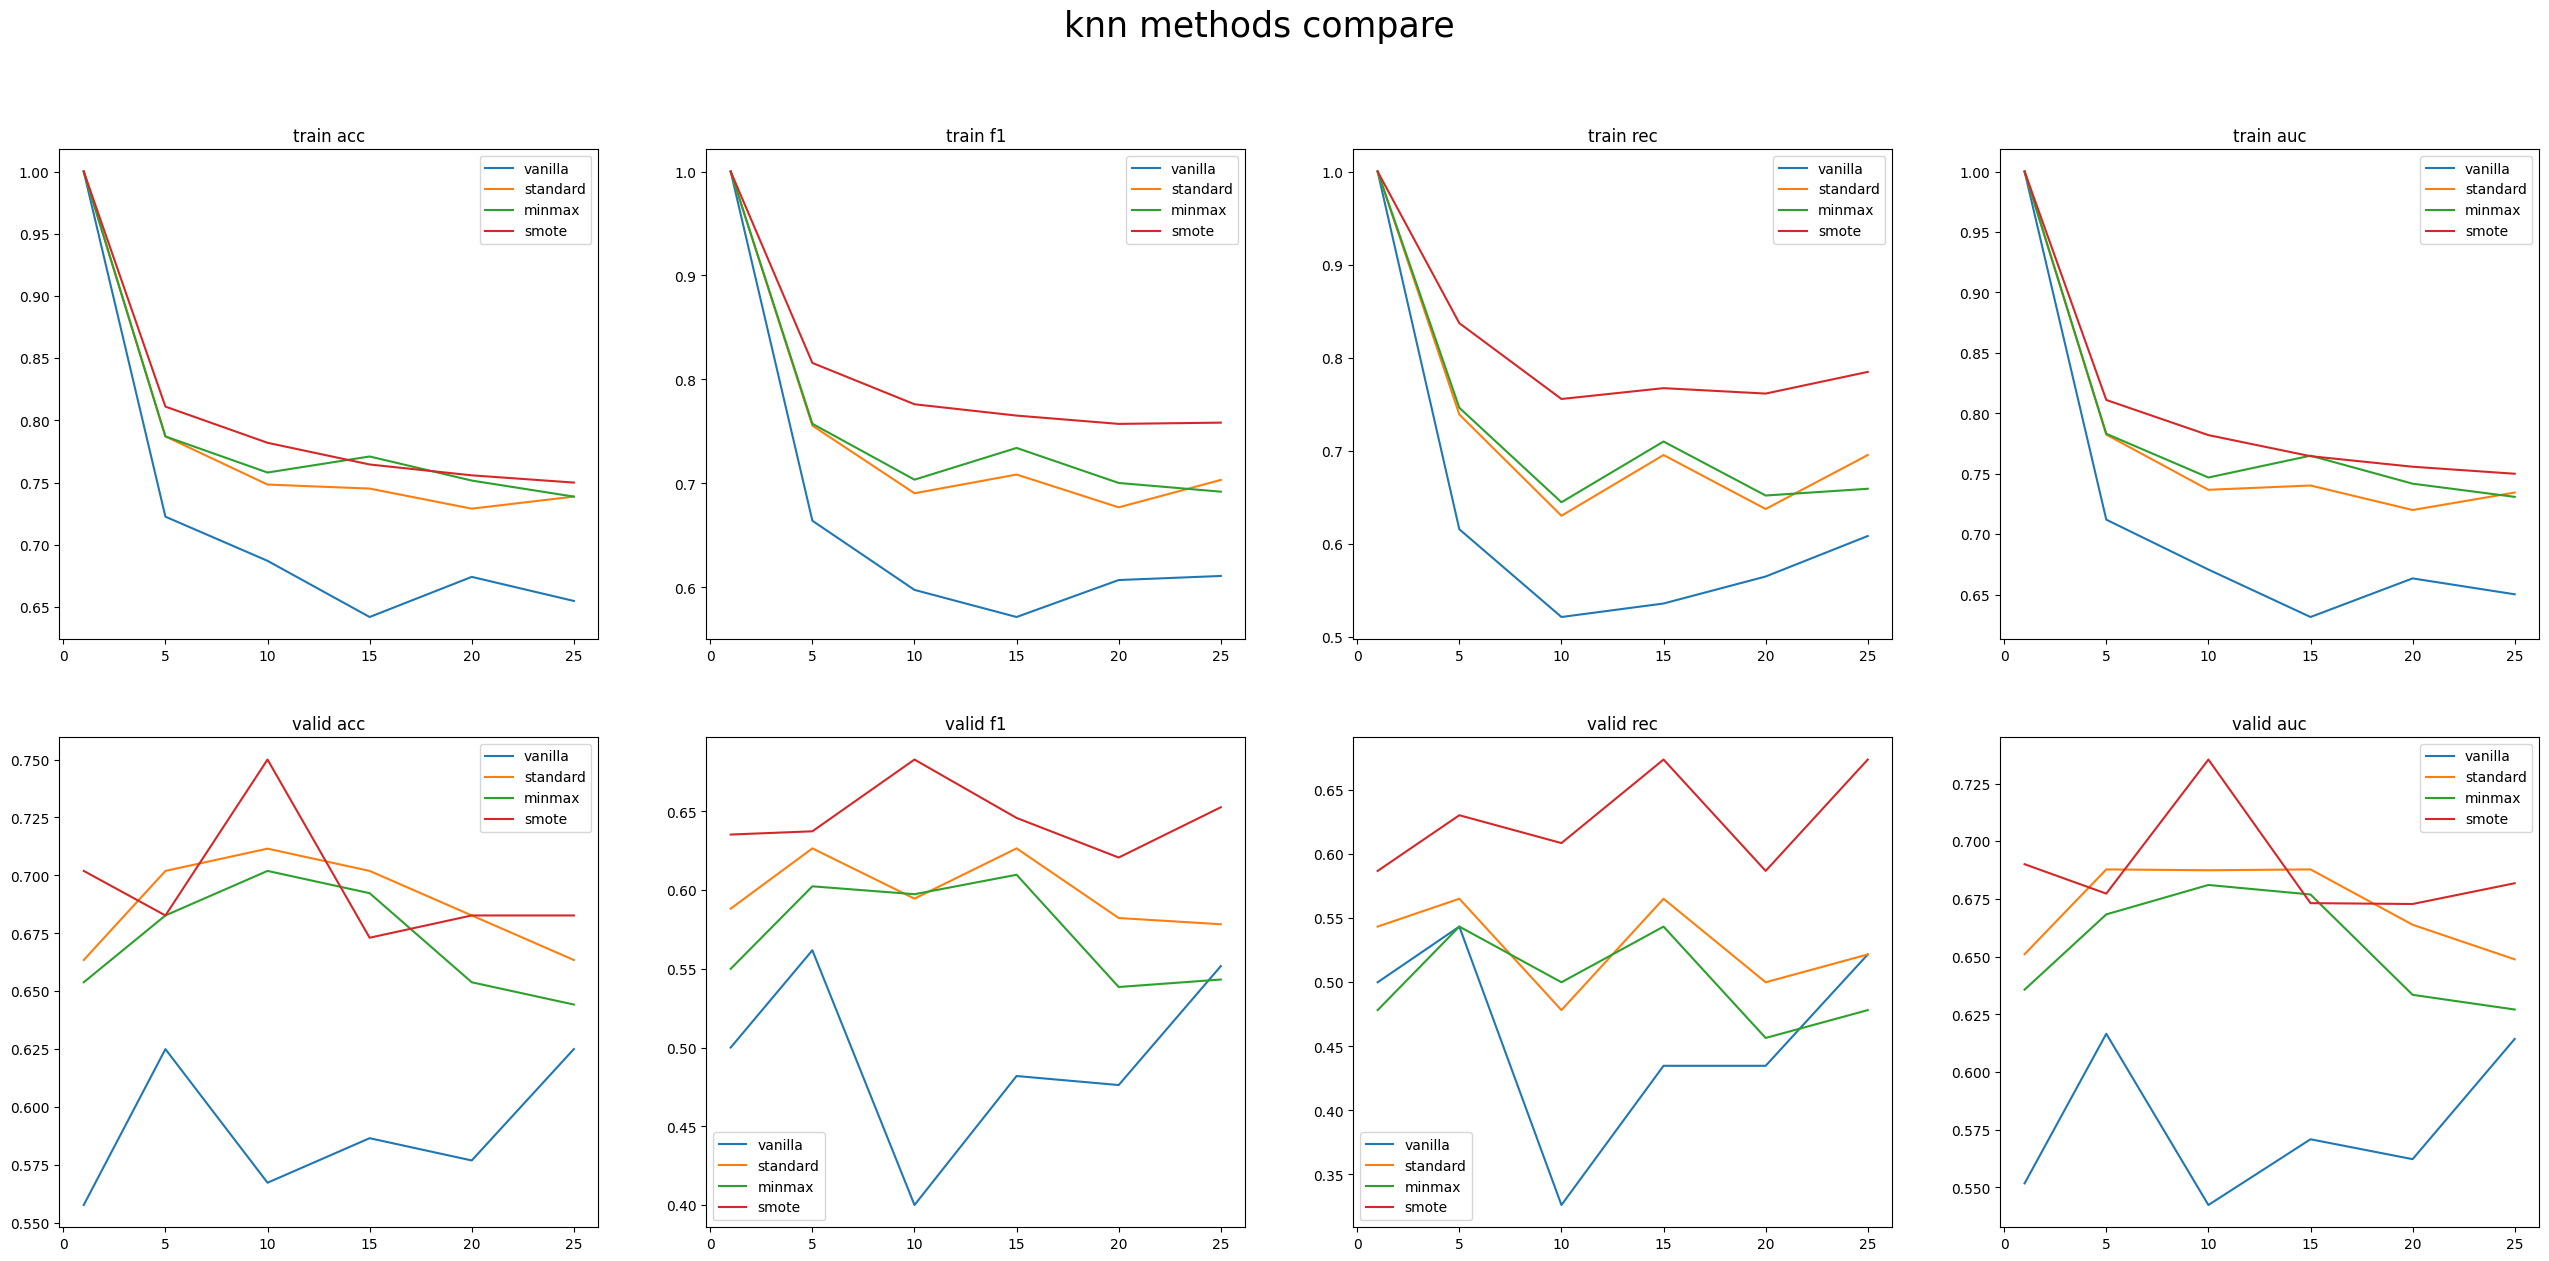

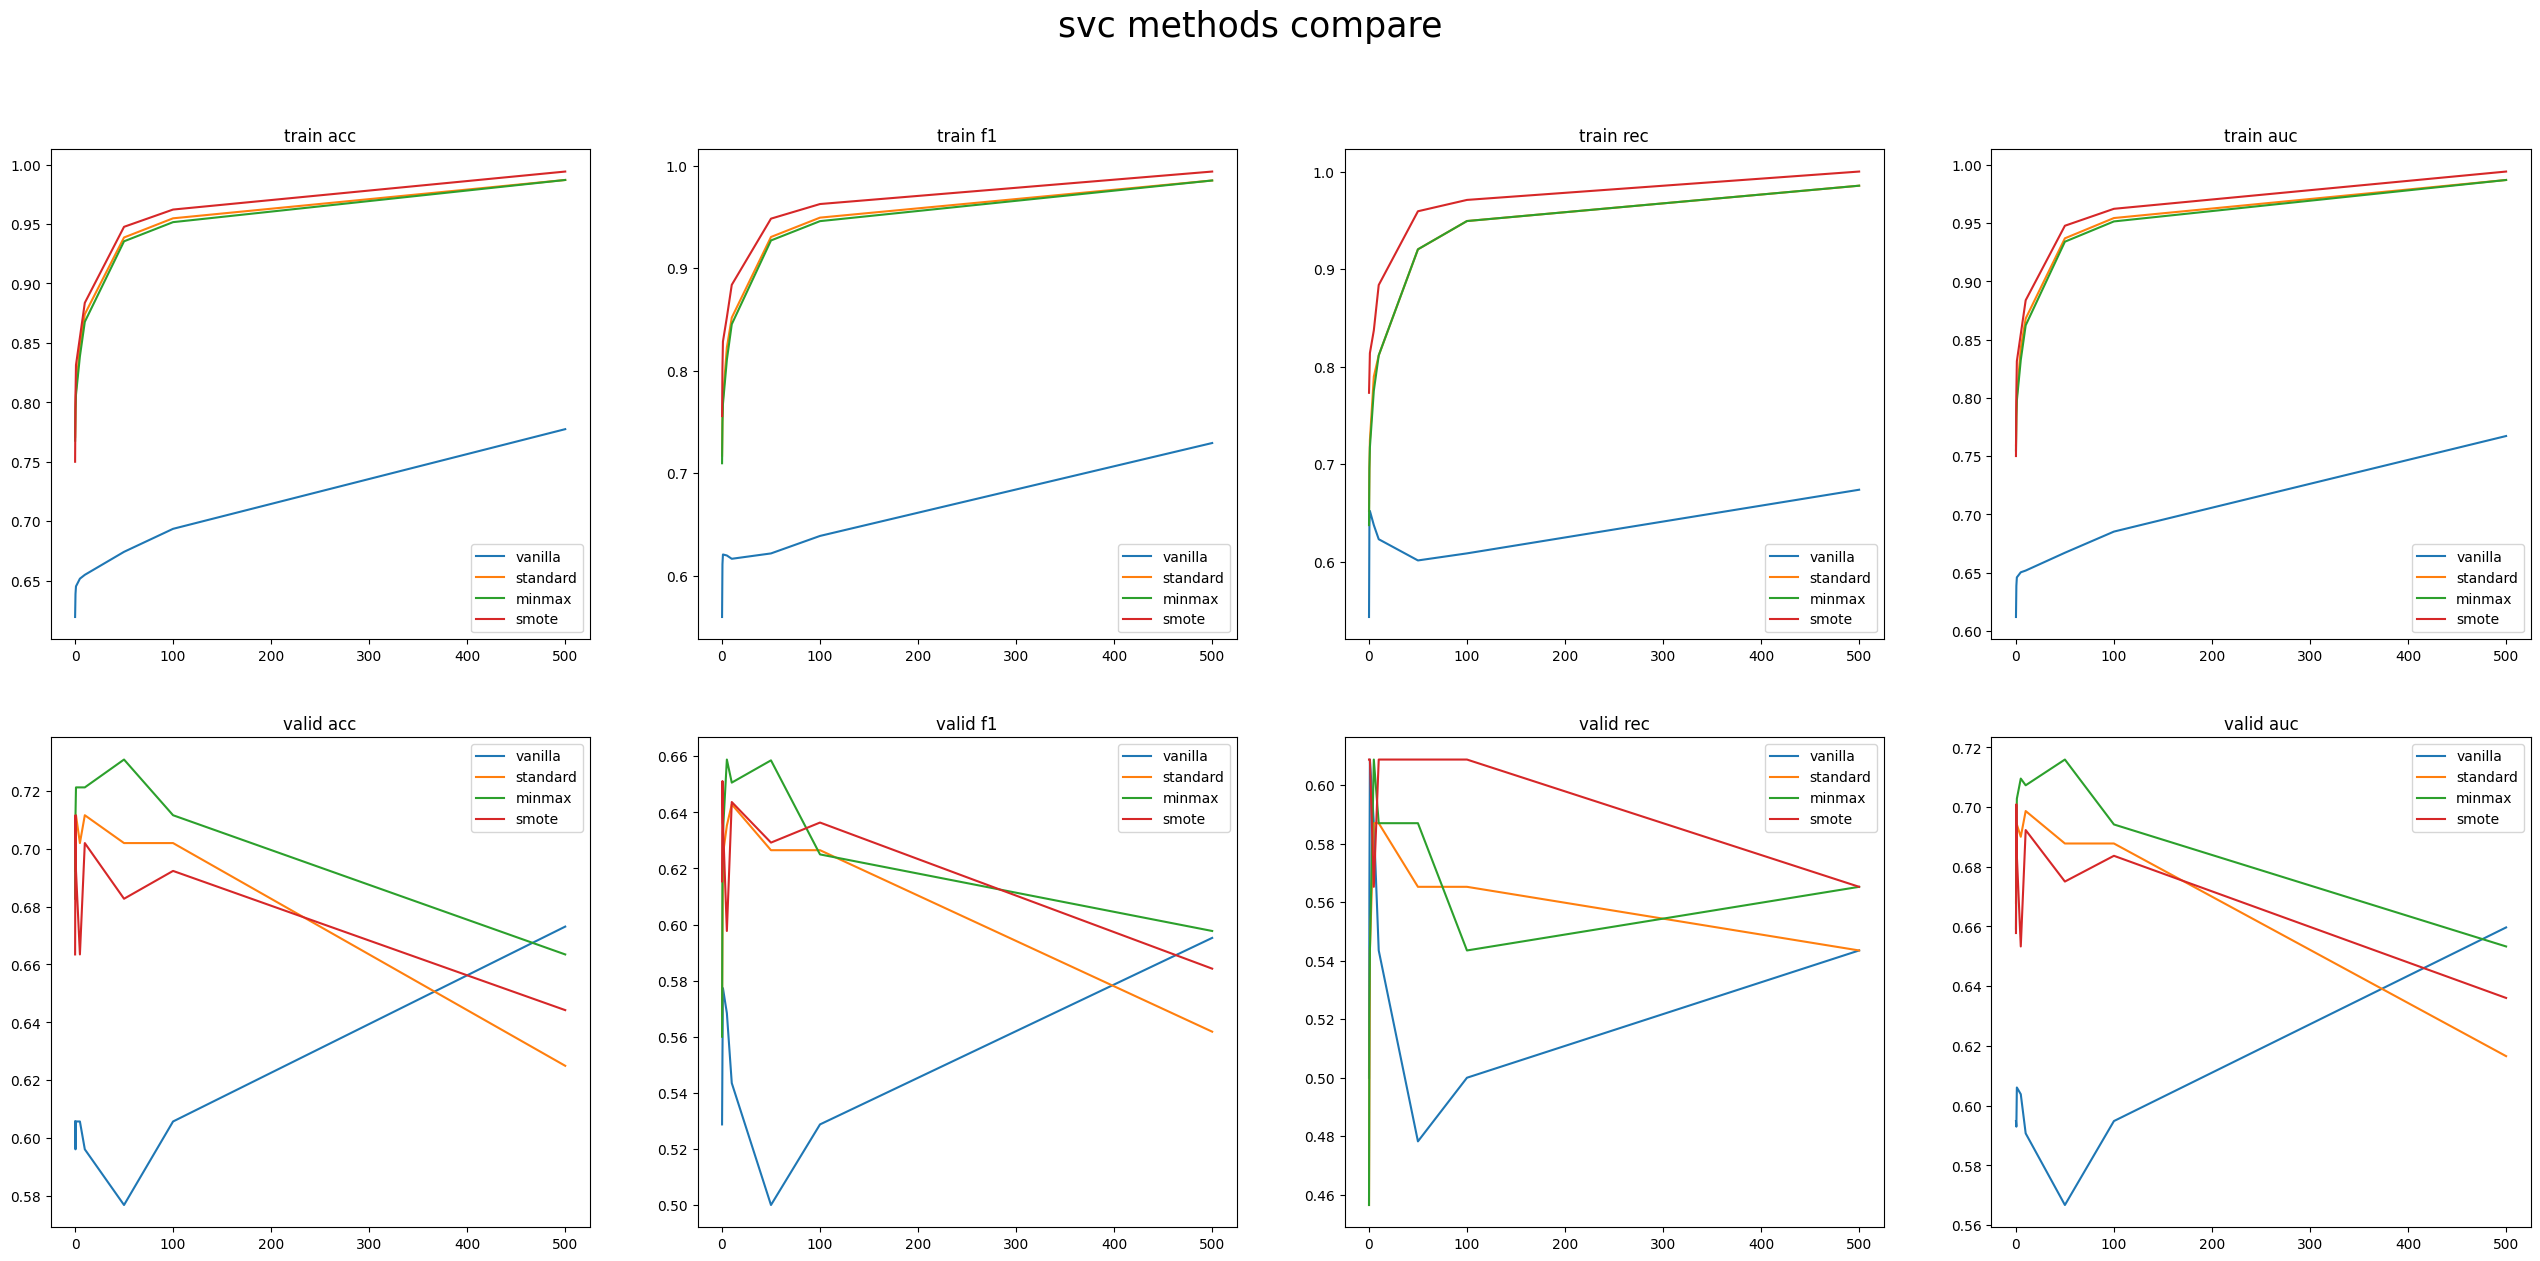

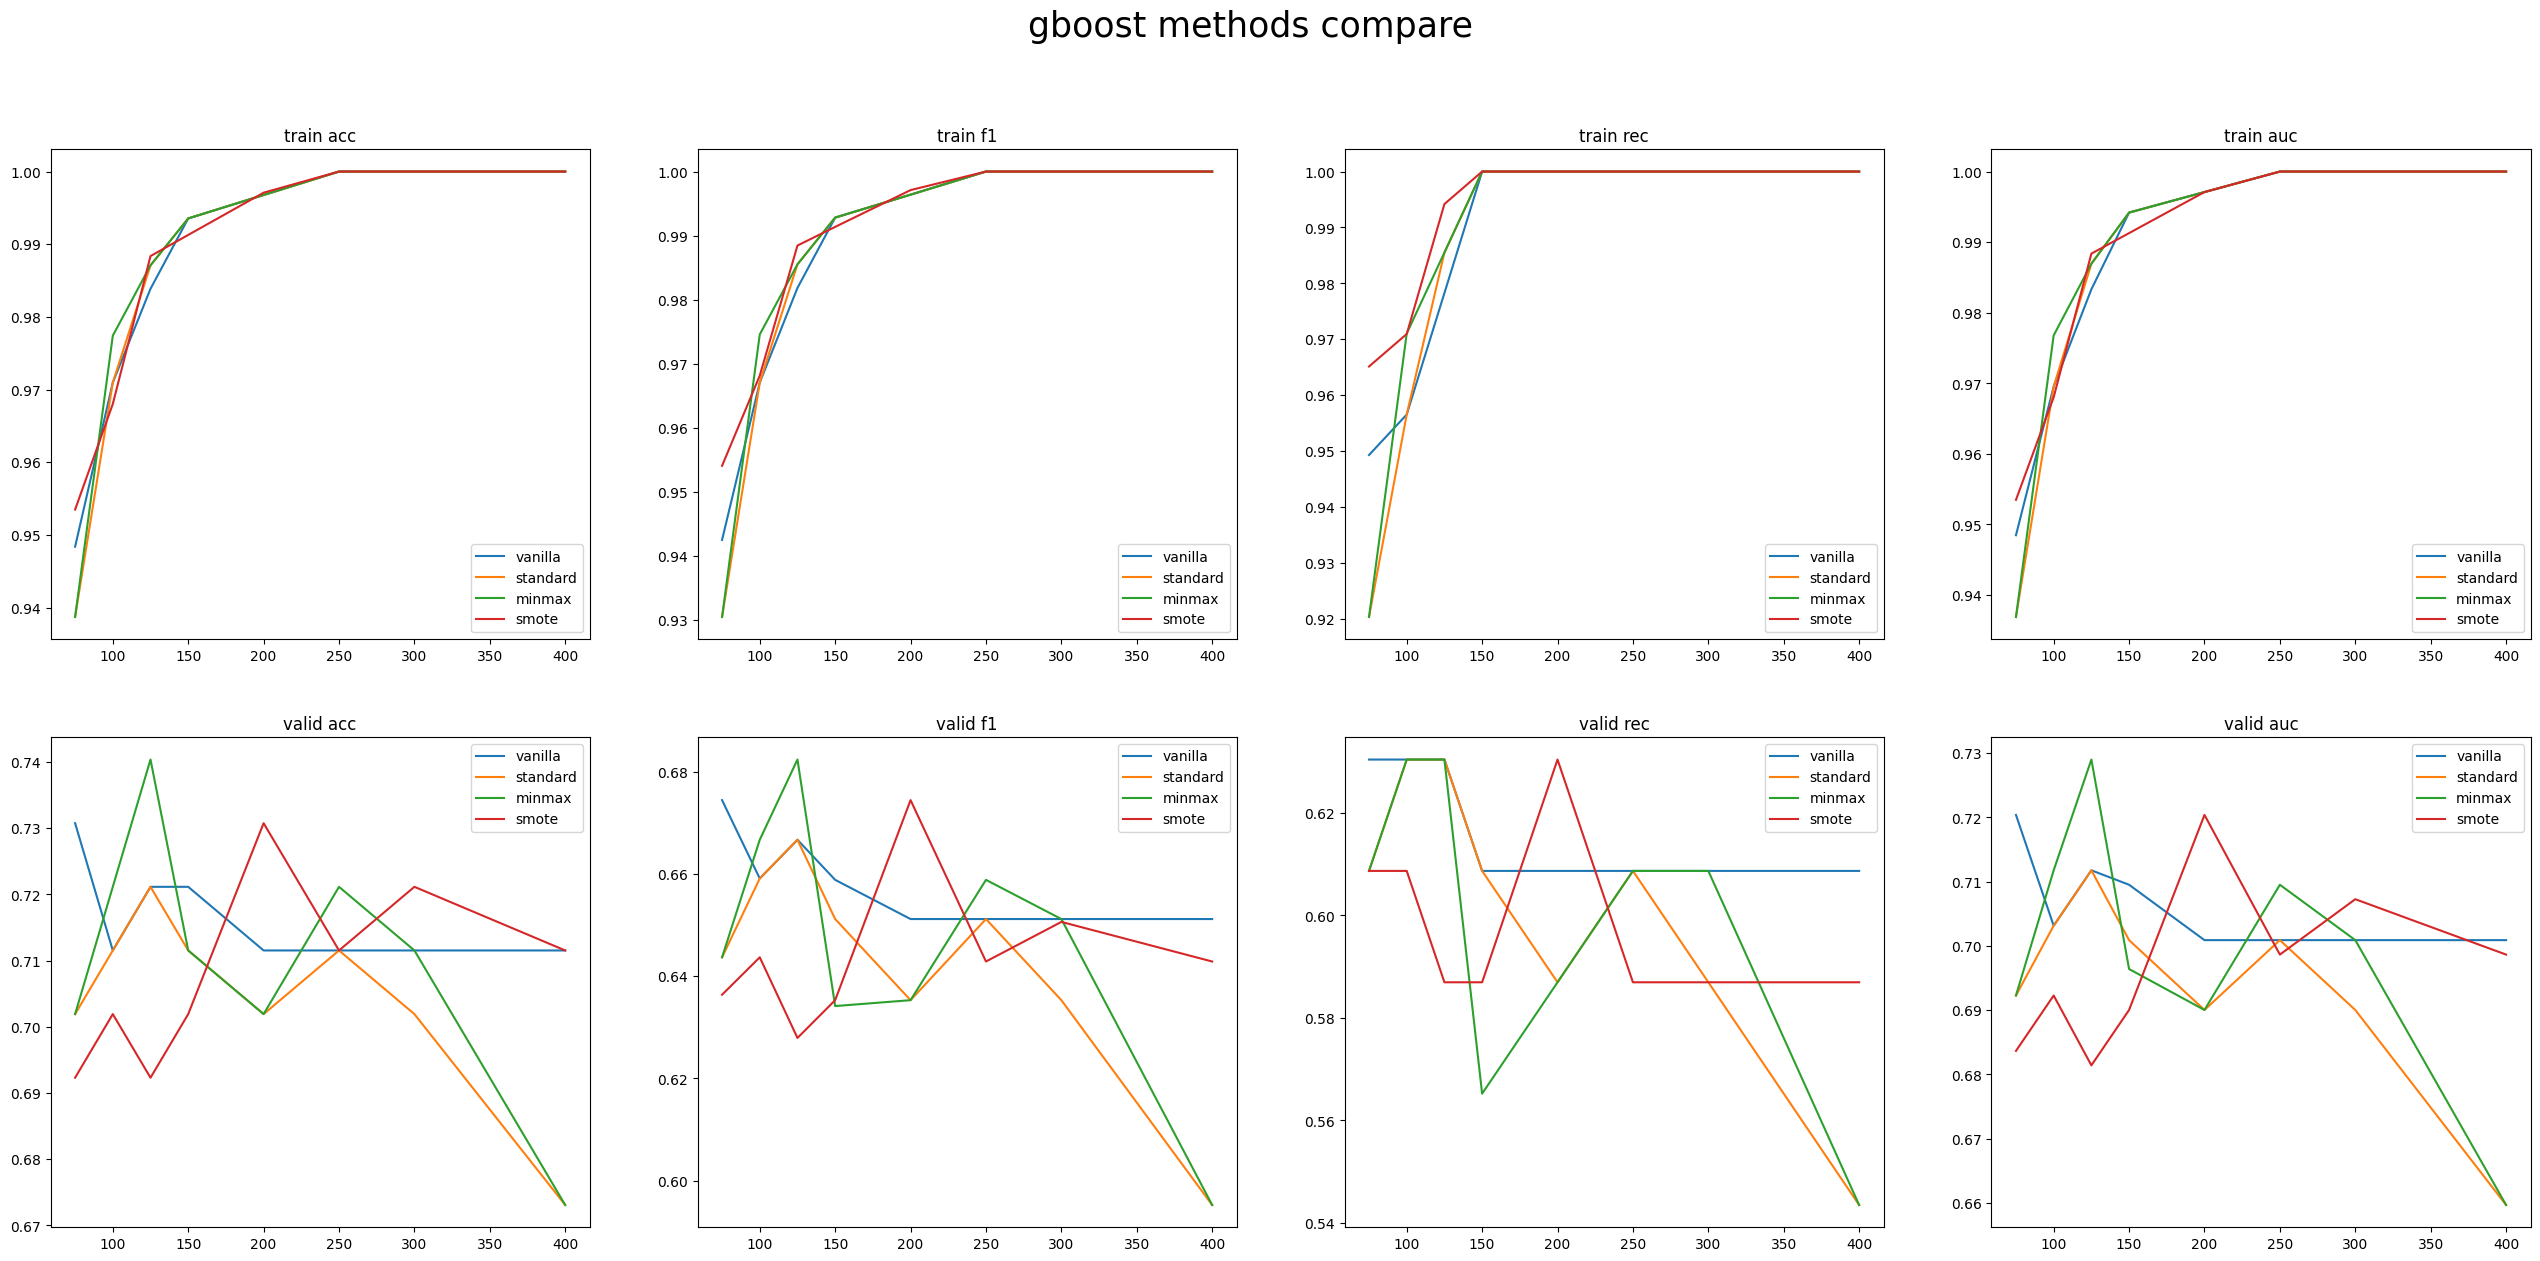

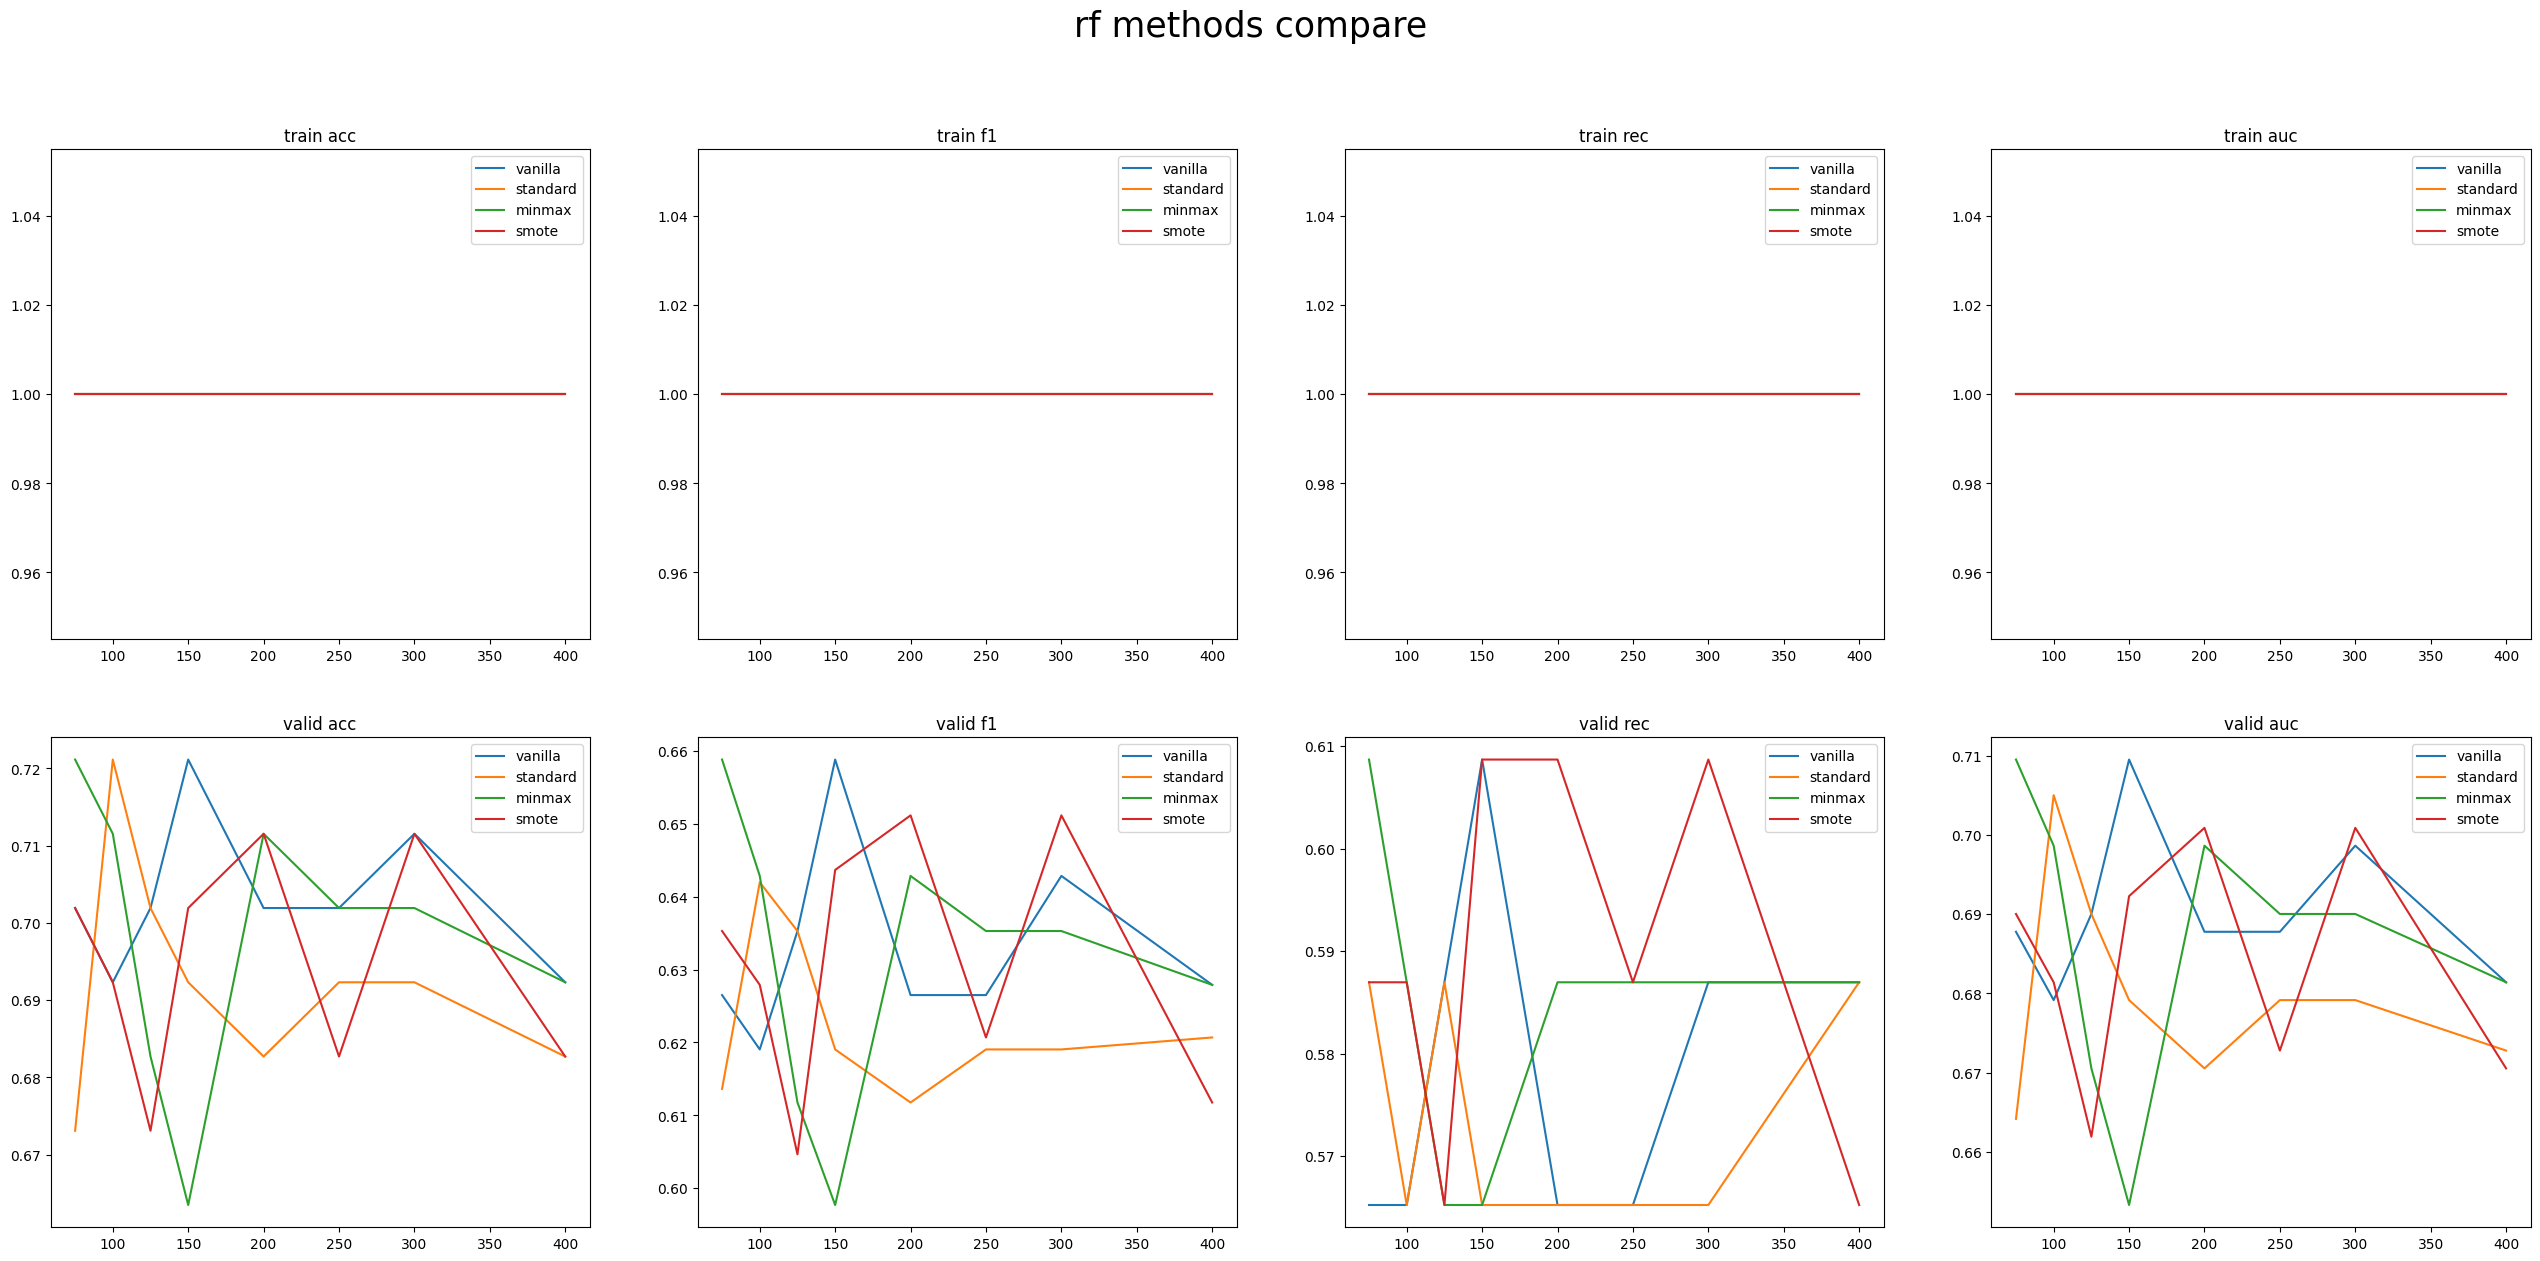

In [29]:
compare_method(total_metric, algo =    'knn', params = K)
compare_method(total_metric, algo =    'svc', params = C) 
compare_method(total_metric, algo = 'gboost', params = N) 
compare_method(total_metric, algo =     'rf', params = N)